# Meteorological conditions during SSW events

In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Definition of functions

In [2]:
def read_group(gruppe, loc):
    station = loc  # ersten Buchstaben bitte bitte groß schreiben

    if loc == "Rio":
        timestart = "2008-02-01"
        timeend = "2019-12-31"
    elif loc == "Col":
        timestart = "2004-08-01"
        timeend = "2019-03-06"
    elif loc == "CMA":
        timestart = "2002-01-01"
        timeend = "2018-12-31"
    elif loc == "Dav":
        timestart = "2005-01-01"
        timeend = "2019-12-31"
    elif loc == "Kir":
        timestart = "1999-08-01"
        timeend = "2019-12-31"

    infiles = f"{root_path}{station}/Meteor_radar_{station}_GW_*.h5"
    if gruppe == "tides":
        ds = xr.open_mfdataset(
            infiles,
            concat_dim="phony_dim_4",
            group=gruppe,
            combine="nested",
            parallel=True,
        )
        ds = ds.rename({"phony_dim_4": "time", "phony_dim_5": "alt"})
    else:
        ds = xr.open_mfdataset(
            infiles,
            concat_dim="phony_dim_6",
            group=gruppe,
            combine="nested",
            parallel=True,
        )
        ds = ds.rename({"phony_dim_6": "time", "phony_dim_7": "alt"})
    ds["alt"] = alt
    ds["alt"].attrs["units"] = "km"
    # change time range according to meteor radar station
    ds["time"] = pd.date_range(start=timestart, end=timeend, periods=ds.time.shape[0])
    return ds

In [3]:
def read_var(gruppe, var):
    varout = gruppe[var]
    return varout

In [4]:
def hwind(u, v):
    return np.sqrt(u ** 2 + v ** 2)

In [5]:
def time_mean(step, var):
    return var.resample(time="1" + step).mean(
        "time"
    )  # Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!

In [6]:
def anomalie(step, var):
    string = "time." + step
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology

    return anomalies

In [7]:
def grav_waves(wind_component, loc):  # Beides muss schon als String reingegeben werden!
    ds = read_group("wind", loc)
    gw = read_var(ds, wind_component) - read_var(ds, wind_component + "_fil")
    return gw

In [8]:
def grav_waves_gaia(
    wind_component, loc_array
):  # Windkomponente muss schon als String reingegeben werden!
    gw = read_var(loc_array, wind_component) - read_var(
        loc_array, wind_component + "_fil"
    )
    return gw

In [9]:
def kin_energy_grav_waves(loc):
    kin_energy = 0.5 * ((grav_waves("u", loc)) ** 2 + (grav_waves("v", loc)) ** 2)
    return kin_energy

In [10]:
def kin_energy_grav_waves_gaia(loc_array):
    kin_energy = 0.5 * (
        (grav_waves_gaia("u", loc_array)) ** 2 + (grav_waves_gaia("v", loc_array)) ** 2
    )
    return kin_energy

#### Superposed Epoch Analysis

In [11]:
def sea(days_period, station, var):
    df_dates = pd.read_csv(
        "ssw_dates_displ_" + station + ".csv"
    )  # you can load SSWs from a csv file like attached
    dates = df_dates.set_index("BeginDate")

    xa_ls = []
    max_lag = days_period
    for il, days in enumerate(range(-max_lag, max_lag + 1)):
        sel_dates = pd.to_datetime(dates.index) + pd.Timedelta(str(days) + " days")
        mask = np.in1d(var.time.dt.floor("1D"), sel_dates)
        comp_m = var.sel(time=mask).mean("time")
        xa_ls.append(comp_m)

    xa_comp = xr.concat(xa_ls, dim="days")
    xa_comp["days"] = range(-max_lag, max_lag + 1)

    # print(xa_comp)
    return xa_comp

## SSW-Events

In [12]:
ssw_events = [
    "2008-02-21",
    "2009-01-23",
    "2010-01-26",
    "2010-02-09",
    "2010-03-24",
    "2011-02-01",
    "2011-03-25",
    "2012-01-17",
    "2013-01-06",
    "2013-01-17",
    "2014-03-31",
    "2015-01-05",
    "2016-03-16",
    "2018-02-12",
]

In [13]:
alt = [
    70,
    72,
    74,
    76,
    78,
    80,
    82,
    84,
    86,
    88,
    90,
    92,
    94,
    96,
    98,
    100,
    102,
    104,
    106,
    108,
    110,
    112,
    114,
    116,
    118,
    120,
]
root_path = "/home/gemeinsam_tmp/UA_students/data/"
# xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Kir/Meteor_radar_Kir_GW_201912.h5', group='info')['day']

## Location of the stations

## Measurements

### Wind

#### Collm

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


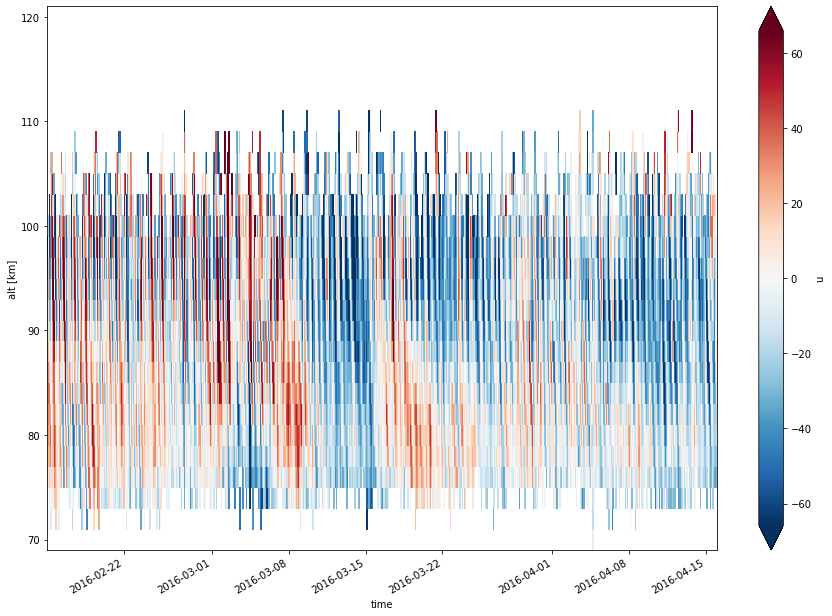

In [14]:
ds_col = read_group("wind", "Col")
u_col = read_var(ds_col, "u")
v_col = read_var(ds_col, "v")

u_col_anomalie = anomalie("hour", u_col)
# u_col_anomalie.plot(x='time',robust=True)

v_col_anomalie = anomalie("day", v_col)

sea_u_col = sea(30, "Col", u_col)
sea_u_col_anomalie = sea(30, "Col", u_col_anomalie)

sea_v_col = sea(30, "Col", v_col)
sea_v_col_anomalie = sea(30, "Col", v_col_anomalie)

u_col_anomalie.sel(time=slice("2016-02-15", "2016-04-15")).plot(
    x="time", size=10, robust=True
)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


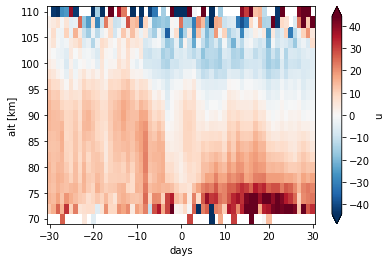

In [15]:
ax1 = sea_u_col.sel(alt=slice(70, 110)).plot(x="days", robust=True)
ax1.figure.savefig("graphics/u_clima_col_small.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


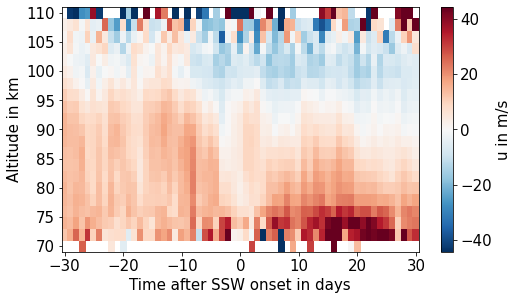

In [16]:
fosi = "15"
vminu = -35
vmaxu = 35
vminv = -12
vmaxv = 12
vmin = -5
vmax = 5
vmaxtrendu = 1
vmaxtrendv = 0.5
cmap = "RdBu_r"

#######################################################################################################################

ax1 = sea_u_col.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
# ax1.figure.savefig('graphics/u_clima_col_small.png')
#######
# u_radar_clima = u_radar.groupby('time.week').mean("time")
# u_radar_clima_slice=u_radar_clima.sel(alt = slice(74,102))

# im=u_radar_clima_slice.plot(x ='week',robust=True,figsize=[25,9],add_colorbar=False,vmin=vminu,vmax=vmaxu,cmap=cmap)

# plt.axvline(x=25, linewidth = 3 , color = 'orange')
# plt.axvline(x=51, linewidth = 3 , color = 'orange')
# plt.axvline(x=52, linewidth = 3 , color = 'orange')
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax1)
cb.set_label(label="u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax1.figure.savefig("graphics/u_clima_col_small.png", bbox_inches="tight")
ax1.figure.savefig("graphics/u_clima_col_small.eps", bbox_inches="tight")

In [71]:
sea_u_col.coords

Coordinates:
  * alt      (alt) int64 70 72 74 76 78 80 82 84 ... 108 110 112 114 116 118 120
  * days     (days) int64 -30 -29 -28 -27 -26 -25 -24 ... 24 25 26 27 28 29 30

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


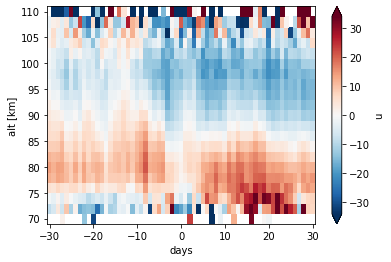

In [72]:
ax2 = sea_u_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True)
ax2.figure.savefig("graphics/u_anomaly_col_small.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


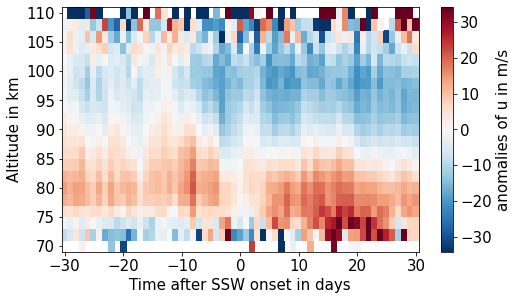

In [73]:
ax2 = sea_u_col_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax2)
cb.set_label(label="anomalies of u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax2.figure.savefig("graphics/u_anomaly_col_small.png", bbox_inches="tight")
ax2.figure.savefig("graphics/u_anomaly_col_small.eps", bbox_inches="tight")

##### Interpretation:
In the time period from 3 weeks until 1 week before the SSW the zonal wind is more western (eastward) than normal (in the mean for the certain calendar day). This maybe could be the upper edge of the intensified jetstream between stratosphere and mesosphere which is typical in the time before SSW's. That was validated with GAIA model data in chapter ?.

Some days before the onset of the SSW's the zonal wind becomes less western (eastward) and maybe even a weak eastern (westward) component. This wind drop is typical for the SSW onset as the polar vortex and the stratospheric jet collapse.

In the month after the SSW we see in the altitudes between 70 and 80 km a very strong increase in the u-component of the wind as well as in the anomalies. That could correspond to the re-establishment of the stratopause which often takes place in this height some weeks after an SSW event. This was also validated with GAIA model data (see chapter ?).

In the altitudes from 90 to 100 km the zonal wind becomes more eastern (westward) with the beginning of the SSW and already around one week before the onset.

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


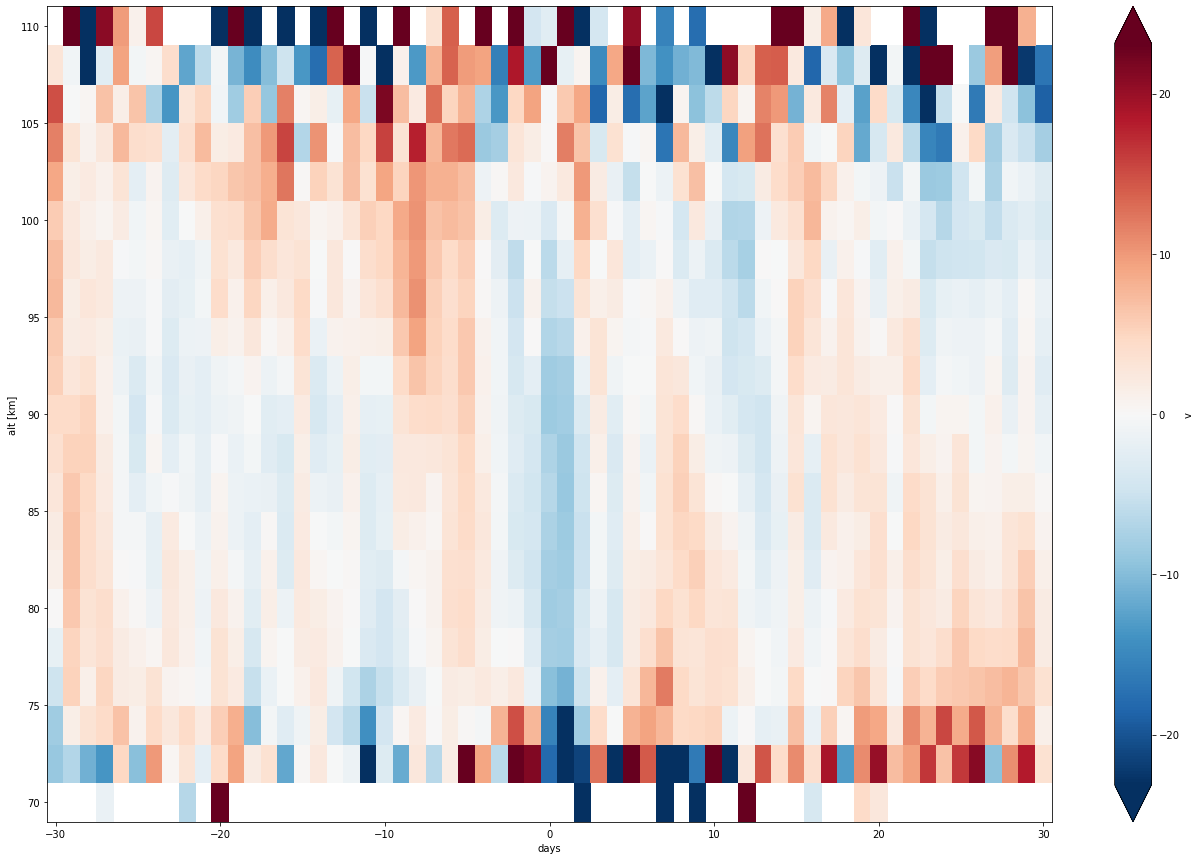

In [74]:
ax3 = sea_v_col.sel(alt=slice(70, 110)).plot(x="days", size=15, robust=True)
ax3.figure.savefig("graphics/v_clima_col.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


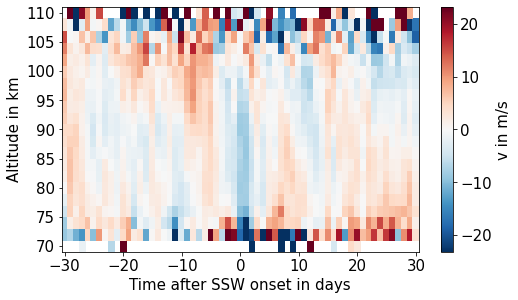

In [75]:
ax3 = sea_v_col.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax3)
cb.set_label(label="v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax3.figure.savefig("graphics/v_clima_col_small.png", bbox_inches="tight")
ax3.figure.savefig("graphics/v_clima_col_small.eps", bbox_inches="tight")

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


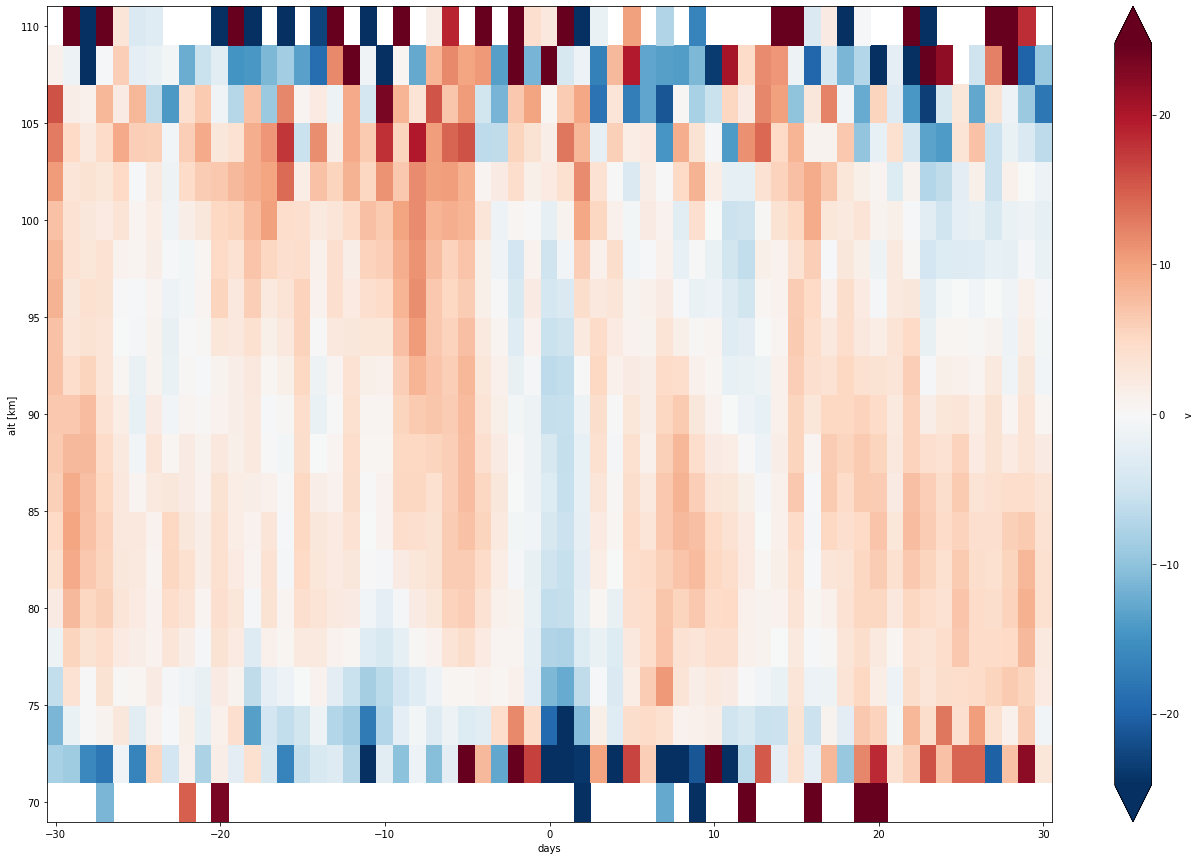

In [76]:
ax4 = sea_v_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", size=15, robust=True)
ax4.figure.savefig("graphics/v_anomaly_col.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


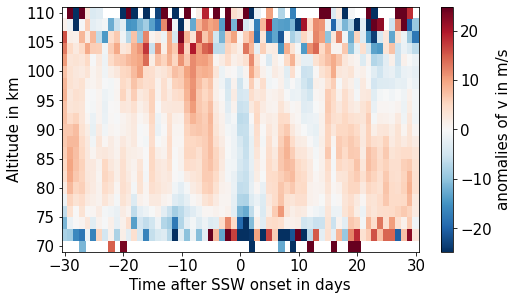

In [77]:
ax4 = sea_v_col_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax4)
cb.set_label(label="anomalies of v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax4.figure.savefig("graphics/v_anomaly_col_small.png", bbox_inches="tight")
ax4.figure.savefig("graphics/v_anomaly_col_small.eps", bbox_inches="tight")

##### Interpretation:
On the day of the SSW onset we see a change in the meridional wind direction from southern (northward) to northern (southward). After the SSW onset it returns to the values like before the SSW nearly immediately. As we don't see any signature in the v-component of gravity waves at this time, the reason may be planetary waves which are typically most well pronounced around the SSW onset as their upward propagation and breaking initiates the SSW events.

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [78]:
ds_cma = read_group("wind", "CMA")
u_cma = read_var(ds_cma, "u")
v_cma = read_var(ds_cma, "v")

u_cma_anomalie = anomalie("day", u_cma)
# u_cma_anomalie.plot(x='time',robust=True)

v_cma_anomalie = anomalie("day", v_cma)

sea_u_cma = sea(30, "CMA", u_cma)
sea_u_cma_anomalie = sea(30, "CMA", u_cma_anomalie)

sea_v_cma = sea(30, "CMA", v_cma)
sea_v_cma_anomalie = sea(30, "CMA", v_cma_anomalie)

##### Climatology of u-component

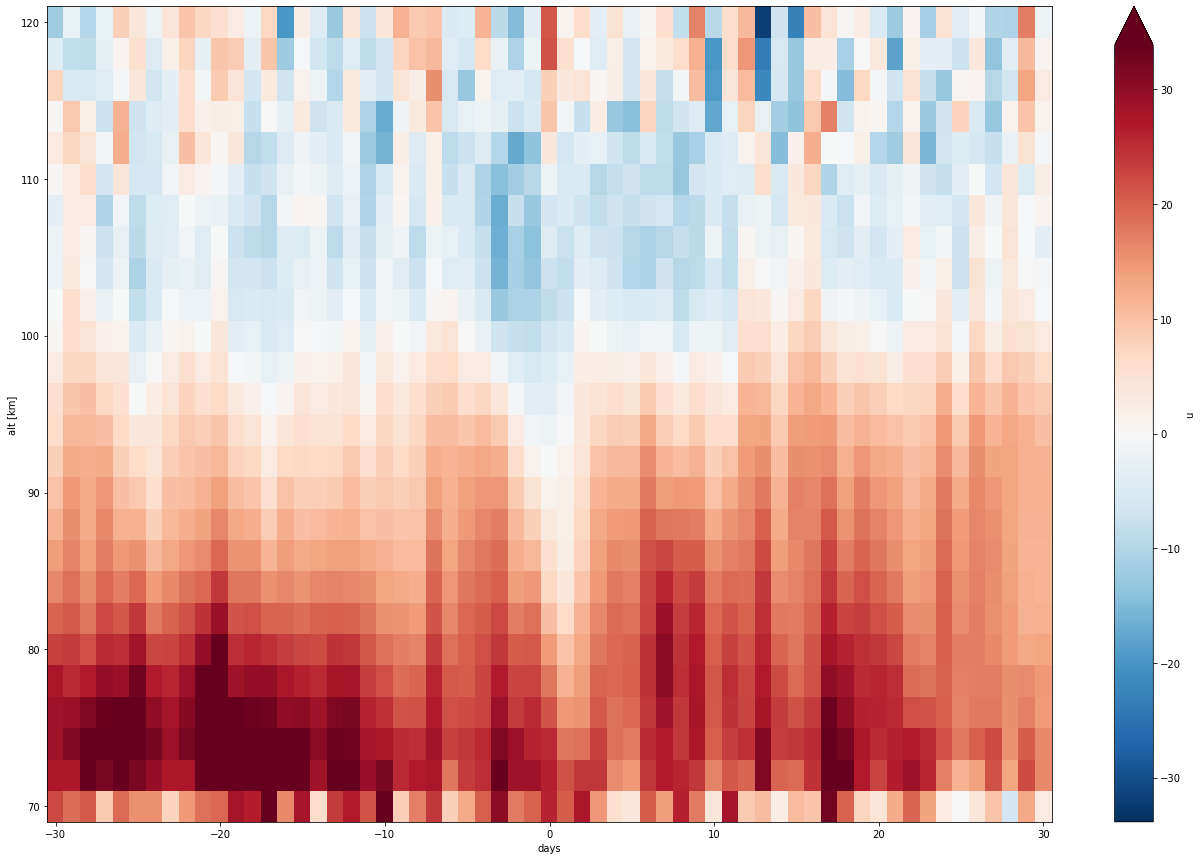

In [79]:
ax5 = sea_u_cma.plot(x="days", size=15, robust=True)
ax5.figure.savefig("graphics/u_clima_cma.png")

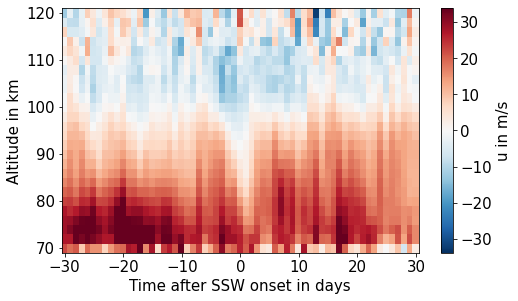

In [80]:
ax5 = sea_u_cma.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax5)
cb.set_label(label="u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax5.figure.savefig("graphics/u_clima_cma_small.png", bbox_inches="tight")
ax5.figure.savefig("graphics/u_clima_cma_small.eps", bbox_inches="tight")

##### Anomalies of u-component

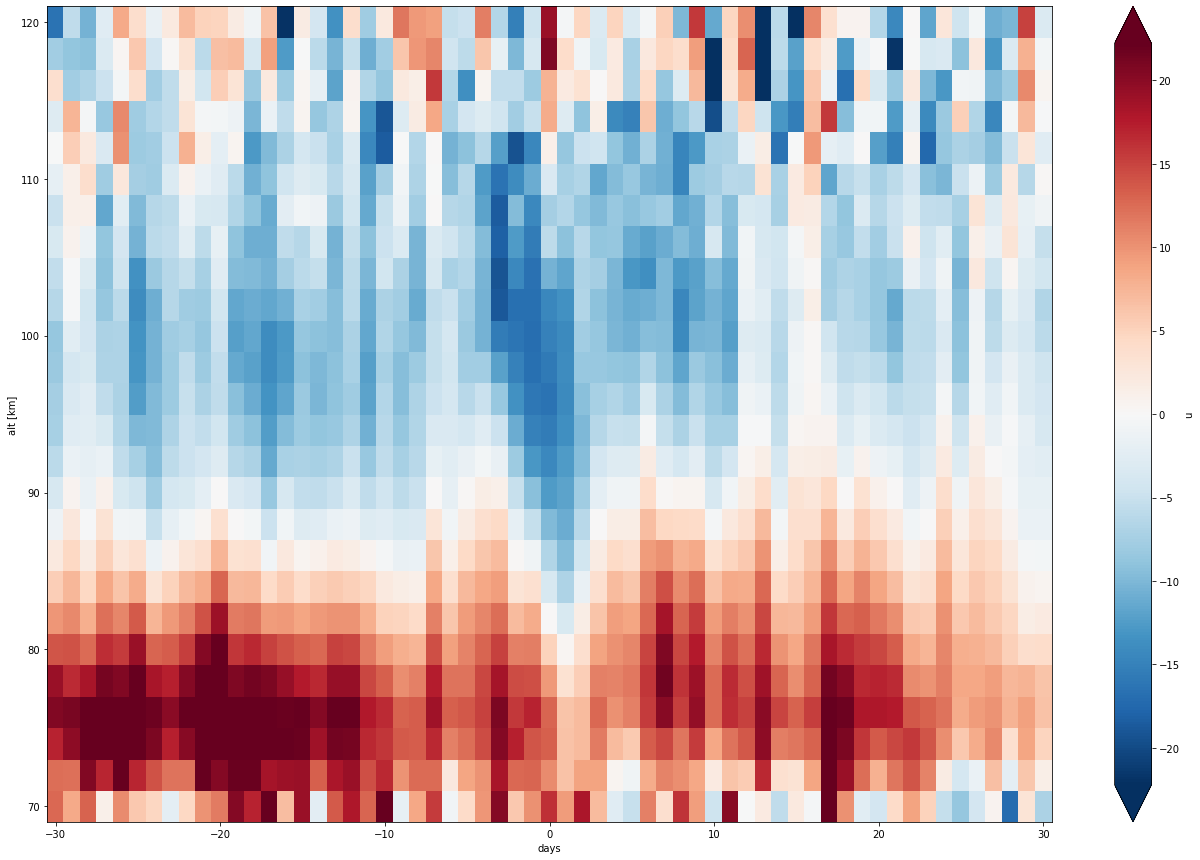

In [81]:
ax6 = sea_u_cma_anomalie.plot(x="days", size=15, robust=True)
ax6.figure.savefig("graphics/u_anomaly_cma.png")

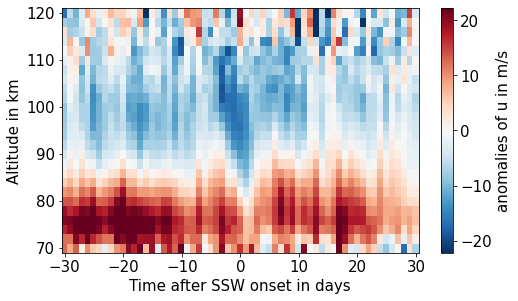

In [82]:
ax6 = sea_u_cma_anomalie.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax6)
cb.set_label(label="anomalies of u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax6.figure.savefig("graphics/u_anomaly_cma_small.png", bbox_inches="tight")
ax6.figure.savefig("graphics/u_anomaly_cma_small.eps", bbox_inches="tight")

##### Interpretation:
The decrease of the western (eastward) component in 70 to 80 km is not as well pronounced as at Collm and Kiruna. But in higher altitudes between 90 and 110 km we see around 4-5 days before the SSW onset the zonal wind becoming more easterly (westward). Especially the anomalies show that, whose signature descends in altitude witth propagating time.
--> Reason? As there is no signature in gravity waves (see chapter ? with the gw-plots) this decrease could probably be caused by planetary waves.

##### Climatology of v-component

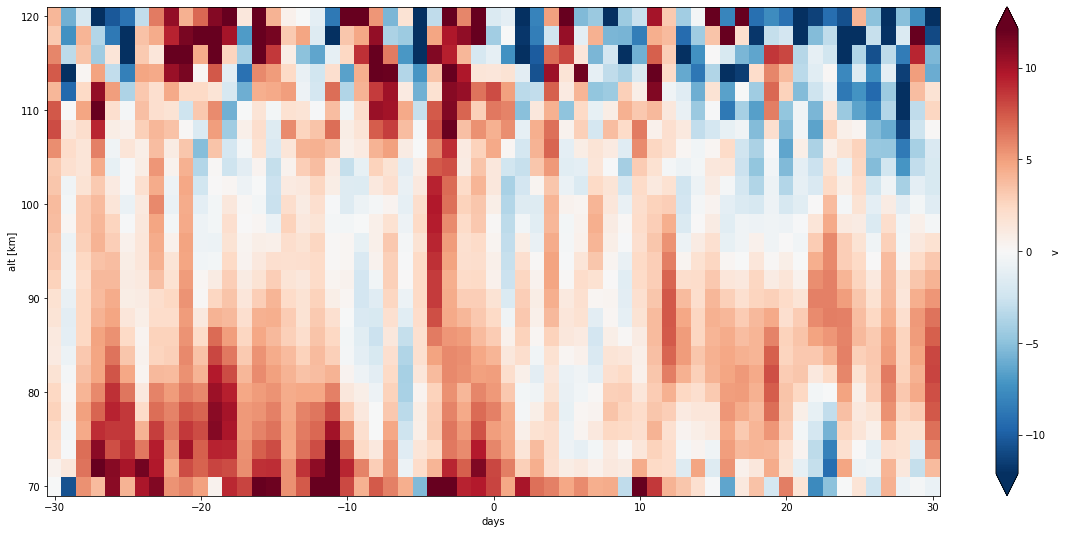

In [83]:
ax7 = sea_v_cma.plot(x="days", robust=True, figsize=[20, 9])
ax7.figure.savefig("graphics/v_clima_cma.png")

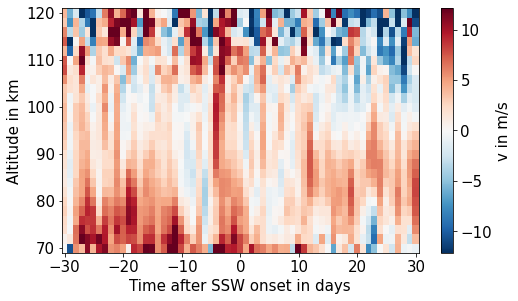

In [84]:
ax7 = sea_v_cma.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax7)
cb.set_label(label="v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax7.figure.savefig("graphics/v_clima_cma_small.png", bbox_inches="tight")
ax7.figure.savefig("graphics/v_clima_cma_small.eps", bbox_inches="tight")

##### Anomalies of v-component

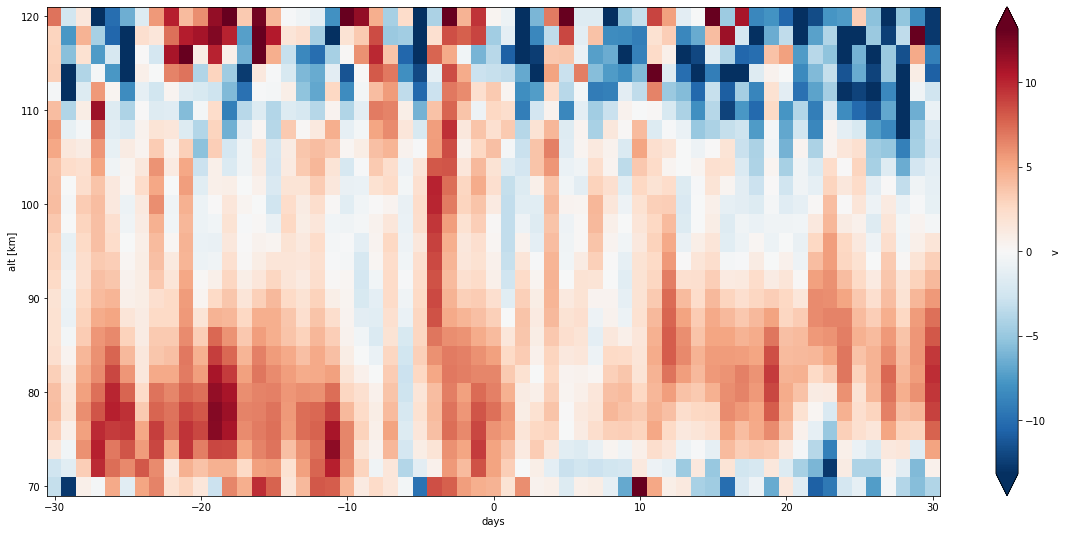

In [85]:
ax8 = sea_v_cma_anomalie.plot(x="days", robust=True, figsize=[20, 9])
ax8.figure.savefig("graphics/v_anomaly_cma.png")

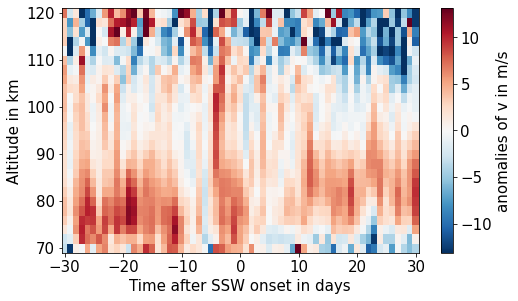

In [86]:
ax8 = sea_v_cma_anomalie.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax8)
cb.set_label(label="anomalies of v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax8.figure.savefig("graphics/v_anomaly_cma_small.png", bbox_inches="tight")
ax8.figure.savefig("graphics/v_anomaly_cma_small.eps", bbox_inches="tight")

##### Interpretation:
At CMA the v-component shows a strong increase and positive anomaly in the mesosphere around a week before the SSW onset. Besides, around 10 - 7 days before the SSW onset and during the 10 days after the SSW onset the western wind is much weaker and at some point already turns to a weak eastern component.
---> Reason? As there is no signature in gravity wave activity this changes in the meridional winds could probably be caused by planetary waves, too.

#### Davis (Antarctic)

In [87]:
ds_dav = read_group("wind", "Dav")
u_dav = read_var(ds_dav, "u")
v_dav = read_var(ds_dav, "v")

u_dav_anomalie = anomalie("day", u_dav)
# u_rio_anomalie.plot(x='time',robust=True)

v_dav_anomalie = anomalie("day", v_dav)

sea_u_dav = sea(30, "Dav", u_dav)
sea_u_dav_anomalie = sea(30, "Dav", u_dav_anomalie)

sea_v_dav = sea(30, "Dav", v_dav)
sea_v_dav_anomalie = sea(30, "Dav", v_dav_anomalie)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


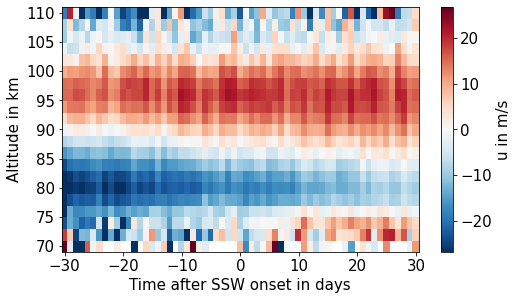

In [88]:
ax9 = sea_u_dav.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax9)
cb.set_label(label="u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax9.figure.savefig("graphics/u_clima_dav_small.png", bbox_inches="tight")
ax9.figure.savefig("graphics/u_clima_dav_small.eps", bbox_inches="tight")

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


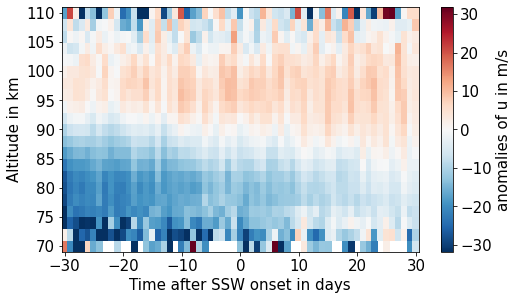

In [89]:
ax10 = sea_u_dav_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax10)
cb.set_label(label="anomalies of u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax10.figure.savefig("graphics/u_anomaly_dav_small.png", bbox_inches="tight")
ax10.figure.savefig("graphics/u_anomaly_dav_small.eps", bbox_inches="tight")

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


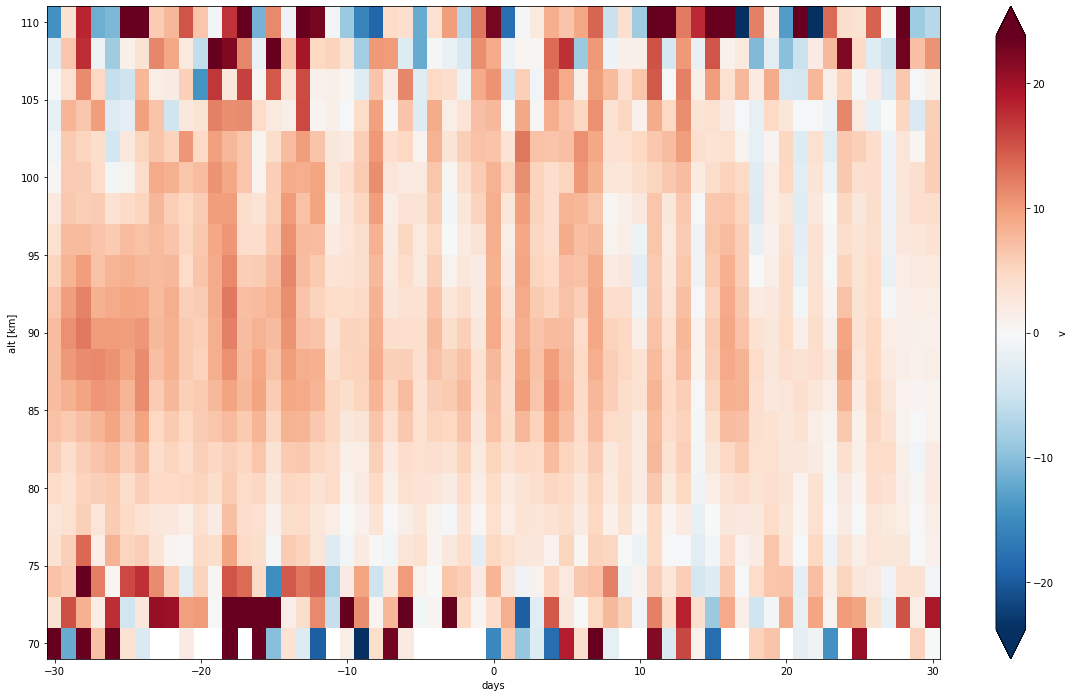

In [90]:
ax11 = sea_v_dav.sel(alt=slice(70, 110)).plot(x="days", robust=True, figsize=[20, 12])
ax11.figure.savefig("graphics/v_clima_dav.png")

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


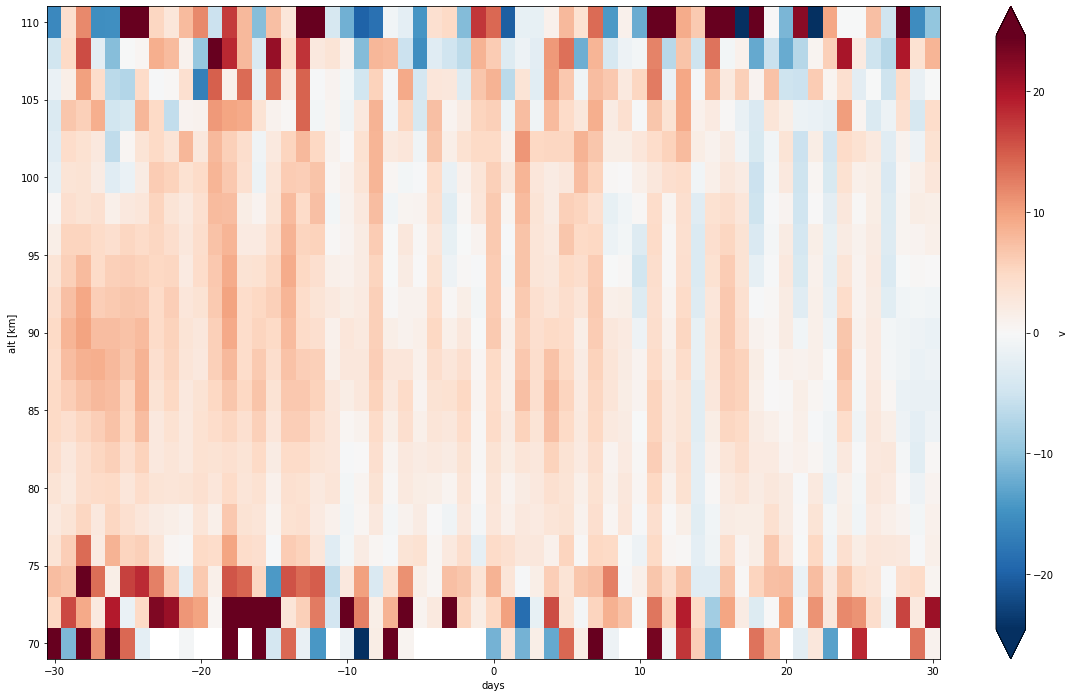

In [91]:
ax12 = sea_v_dav_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[20, 12]
)
ax12.figure.savefig("graphics/v_anomaly_dav.png")

##### Interpretation:
Davis shows the least changes of the 5 stations. There are only very slight changes in the zonal wind component and the anomalies are of small magnitude. This seems logic as it is situated in the Antarctic and therefore is the southernmost station with the greatest distance to the northern hemispheric polar vortex where the SSW events occur.

#### Rio Grande

In [92]:
ds_rio = read_group("wind", "Rio")
u_rio = read_var(ds_rio, "u")
v_rio = read_var(ds_rio, "v")

u_rio_anomalie = anomalie("day", u_rio)
# u_rio_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie("day", v_rio)

sea_u_rio = sea(30, "Rio", u_rio)
sea_u_rio_anomalie = sea(30, "Rio", u_rio_anomalie)

sea_v_rio = sea(30, "Rio", v_rio)
sea_v_rio_anomalie = sea(30, "Rio", v_rio_anomalie)

##### Climatology of u-component

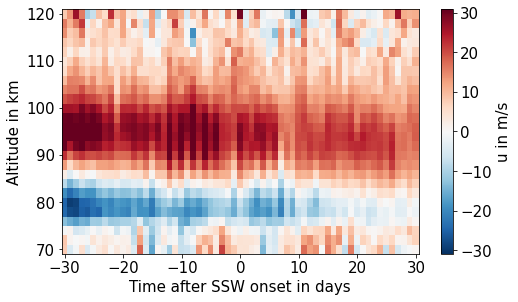

In [93]:
ax13 = sea_u_rio.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax13)
cb.set_label(label="u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax13.figure.savefig("graphics/u_clima_rio_small.png", bbox_inches="tight")
ax13.figure.savefig("graphics/u_clima_rio_small.eps", bbox_inches="tight")

##### Anomalies of u-component

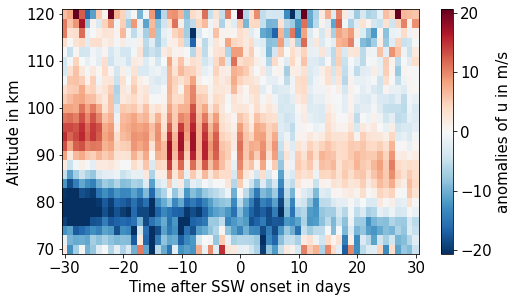

In [94]:
ax14 = sea_u_rio_anomalie.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax14)
cb.set_label(label="anomalies of u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax14.figure.savefig("graphics/u_anomaly_rio_small.png", bbox_inches="tight")
ax14.figure.savefig("graphics/u_anomaly_rio_small.eps", bbox_inches="tight")

##### Interpretation

At the radar station at the Rio Grande in Argentina the zonal wind speeds tend to decrease in magnitude (in both directions) after the onset of the SSWs. The easterly (westward) in around 80 km becomes less easterly and the westerly (eastward) one between 90 and 100 km becomes less westerly.
--> Reason? --> maybe inter-hemispheric coupling???

But all in all the winds are still stronger than in the climatological mean for the corresponding calendar day.

##### Climatology of v-component

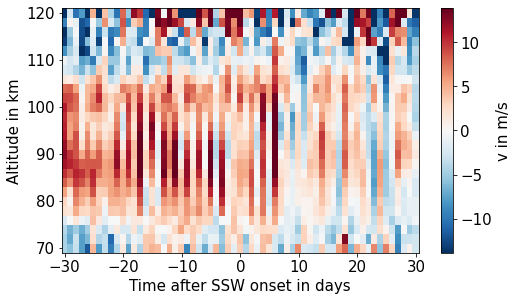

In [95]:
ax15 = sea_v_rio.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax15)
cb.set_label(label="v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax15.figure.savefig("graphics/v_clima_rio_small.png", bbox_inches="tight")
ax15.figure.savefig("graphics/v_clima_rio_small.eps", bbox_inches="tight")

##### Anomalies of v-component

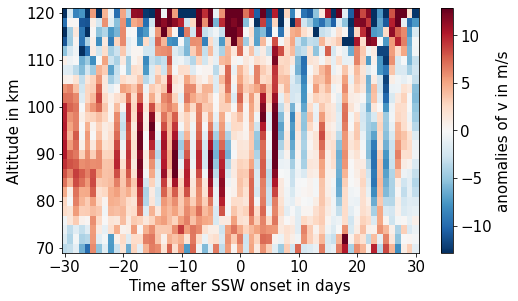

In [96]:
ax16 = sea_v_rio_anomalie.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax16)
cb.set_label(label="anomalies of v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax16.figure.savefig("graphics/v_anomaly_rio_small.png", bbox_inches="tight")
ax16.figure.savefig("graphics/v_anomaly_rio_small.eps", bbox_inches="tight")

##### Interpretation:
The meridional wind component also doesn't show well structured changes because it is on the summer hemisphere, too. (Argentina) There are quite fast fluctuations (stripes)which decrease in magnitude as well with the SSW onset.
--> Reason? --> again maybe inter-hemispheric coupling???

#### Kiruna, Norrbotten (Sweden)

In [97]:
ds_kir = read_group("wind", "Kir")
u_kir = read_var(ds_kir, "u")
v_kir = read_var(ds_kir, "v")

u_kir_anomalie = anomalie("day", u_kir)
# u_rio_anomalie.plot(x='time',robust=True)

v_kir_anomalie = anomalie("day", v_kir)

sea_u_kir = sea(30, "Kir", u_kir)
sea_u_kir_anomalie = sea(30, "Kir", u_kir_anomalie)

sea_v_kir = sea(30, "Kir", v_kir)
sea_v_kir_anomalie = sea(30, "Kir", v_kir_anomalie)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


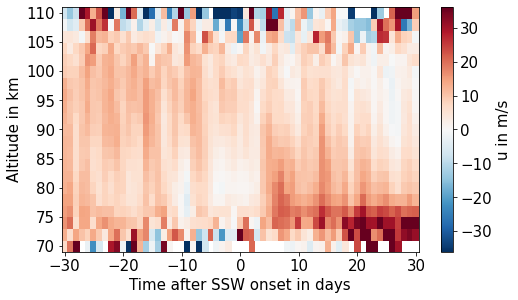

In [98]:
ax17 = sea_u_kir.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax17)
cb.set_label(label="u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax17.figure.savefig("graphics/u_clima_kir_small.png", bbox_inches="tight")
ax17.figure.savefig("graphics/u_clima_kir_small.eps", bbox_inches="tight")

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


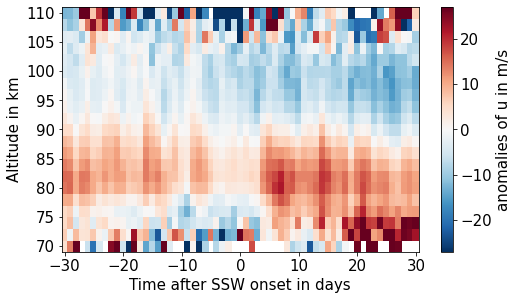

In [99]:
ax18 = sea_u_kir_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax18)
cb.set_label(label="anomalies of u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax18.figure.savefig("graphics/u_anomaly_kir_small.png", bbox_inches="tight")
ax18.figure.savefig("graphics/u_anomaly_kir_small.eps", bbox_inches="tight")

##### Interpretation:
Kiruna in northern Sweden is our northernmost station and quite similar to Collm. The strong increase of the western (eastward) wind at 70 km (probably due to elevated stratopause) is well pronounced at around 20-30 days after the SSW onset.

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


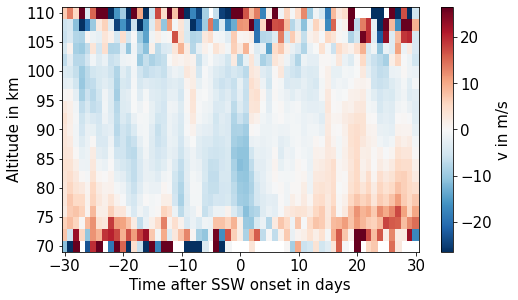

In [100]:
ax19 = sea_v_kir.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax19)
cb.set_label(label="v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax19.figure.savefig("graphics/v_clima_kir_small.png", bbox_inches="tight")
ax19.figure.savefig("graphics/v_clima_kir_small.eps", bbox_inches="tight")

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


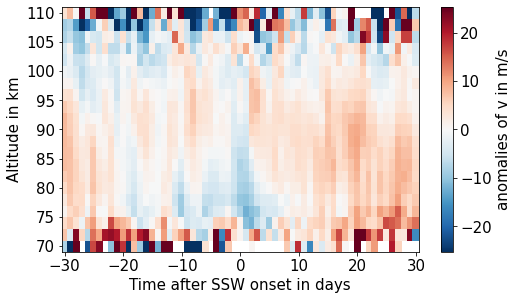

In [101]:
ax20 = sea_v_kir_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax20)
cb.set_label(label="anomalies of v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax20.figure.savefig("graphics/v_anomaly_kir_small.png", bbox_inches="tight")
ax20.figure.savefig("graphics/v_anomaly_kir_small.eps", bbox_inches="tight")

##### Interpretation:
Also quite similar to Collm. The negative anomalies and the increasing northern (southward) direction of the meridional wind component are spread wider concerning time than at Collm observatory. They begin around 2-3 days before the onset of the SSW's and last until 2-3 days after it as well.

### Gravity waves

#### Collm

In [17]:
gw_u_col = grav_waves("u", "Col")
gw_v_col = grav_waves("v", "Col")
# gw_total_energy_neu_col = 0.5*(gw_u_col**2 + gw_v_col**2)
gw_total_energy_col = kin_energy_grav_waves("Col")

sea_gw_u_col = sea(60, "Col", gw_u_col)
sea_gw_v_col = sea(60, "Col", gw_v_col)

# sea_gw_total_energy_neu_col = sea(60,'Col',gw_total_energy_neu_col)
sea_gw_total_energy_col = sea(60, "Col", gw_total_energy_col)


gw_total_energy_col_anomalie = anomalie("day", gw_total_energy_col)
gw_u_col_anomalie = anomalie("day", gw_u_col)
gw_v_col_anomalie = anomalie("day", gw_v_col)


sea_gw_total_energy_col_anomalie = sea(60, "Col", gw_total_energy_col_anomalie)
sea_gw_u_col_anomalie = sea(60, "Col", gw_u_col_anomalie)
sea_gw_v_col_anomalie = sea(60, "Col", gw_v_col_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


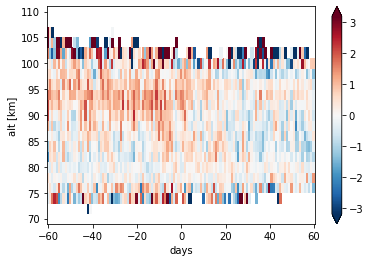

In [53]:
ax21 = sea_gw_u_col.sel(alt=slice(70, 110)).plot(x="days", robust=True)
ax21.figure.savefig("graphics/gw_u_clima_col.png")

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


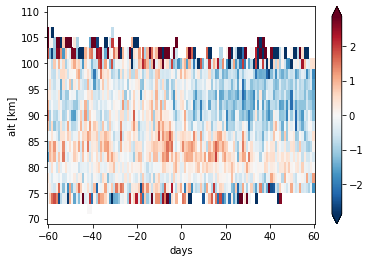

In [54]:
ax22 = sea_gw_u_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True)
ax22.figure.savefig("graphics/gw_u_anomaly_col.png")

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


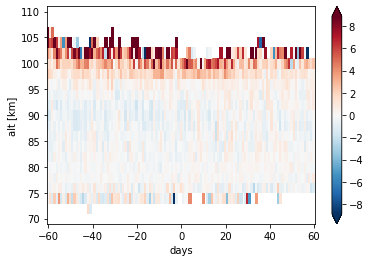

In [55]:
ax23 = sea_gw_v_col.sel(alt=slice(70, 110)).plot(x="days", robust=True)
ax23.figure.savefig("graphics/gw_v_clima_col.png")

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


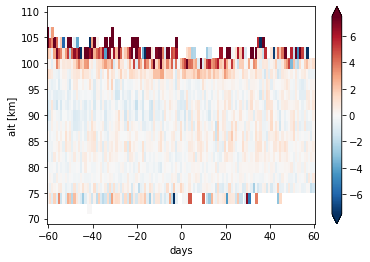

In [56]:
ax24 = sea_gw_v_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True)
ax24.figure.savefig("graphics/gw_v_anomaly_col.png")

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


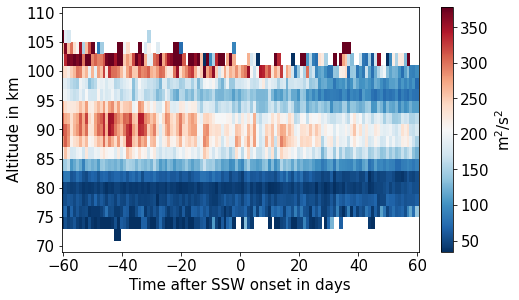

In [21]:
ax25 = sea_gw_total_energy_col.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax25)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax25.figure.savefig("graphics/gw_total_energy_col_small.png", bbox_inches="tight")
ax25.figure.savefig("graphics/gw_total_energy_col_small.eps", bbox_inches="tight")

Observation: After the onset of the SSW the kinetic energy of the gravity waves shows a slight decrease. This would mean that around and after SSW's less or at least weaker gravity waves are present in the Mesosphere. Especially the zonal component shows this decrease as well.

But when we look in the plots of the anomalies, it can be seen that the lower gravity wave activity after the SSW onset is normal with respect to the climatology, while the higher activity in 60 days before the SSWs is anomalous (high anomlies). This means that the radar observations show an increased level of gravity wave activity in altitudes between 85 and 95 km during the 2 months before the onsets of the SSWs.

Kiruna paints a similar picture while the CMA Meteor radar measures the increases in gravity wave activity before the SSWs with weaker magnitude (the increase and the anomalies are less pronounced).

Notiz: Vielleicht aber nur die Energie zeigen und nicht noch die einzelnen Komponenten - das wird sonst zu viel... --> Nein! Auf jeden Fall mindestens einmal die Unterscheidung machen, um zu zeigen welche Komponente dominiert und auch welche Richtung sie aufzeigt (Ost oder West)!!!

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


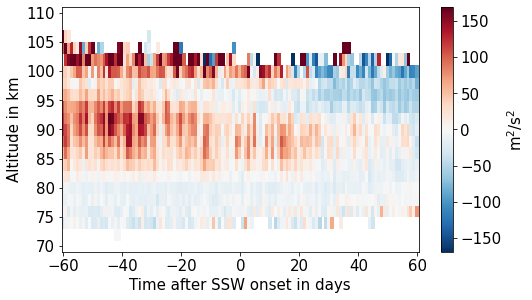

In [22]:
ax26 = sea_gw_total_energy_col_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax26)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax26.figure.savefig(
    "graphics/gw_total_energy_col_anomaly_small.png", bbox_inches="tight"
)
ax26.figure.savefig(
    "graphics/gw_total_energy_col_anomaly_small.eps", bbox_inches="tight"
)

#### Rio Grande

In [23]:
gw_total_energy_rio = kin_energy_grav_waves("Rio")

sea_gw_total_energy_rio = sea(60, "Rio", gw_total_energy_rio)


gw_total_energy_rio_anomalie = anomalie("day", gw_total_energy_rio)

sea_gw_total_energy_rio_anomalie = sea(60, "Rio", gw_total_energy_rio_anomalie)


gw_u_rio = grav_waves("u", "Rio")
gw_v_rio = grav_waves("v", "Rio")

sea_gw_u_rio = sea(60, "Rio", gw_u_rio)
sea_gw_v_rio = sea(60, "Rio", gw_v_rio)

gw_u_rio_anomalie = anomalie("day", gw_u_rio)
gw_v_rio_anomalie = anomalie("day", gw_v_rio)

sea_gw_u_rio_anomalie = sea(60, "Rio", gw_u_rio_anomalie)
sea_gw_v_rio_anomalie = sea(60, "Rio", gw_v_rio_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


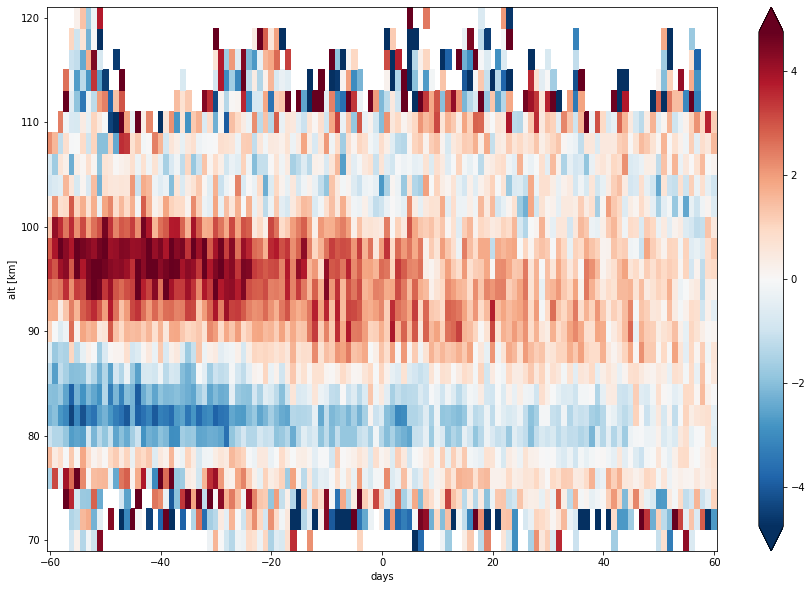

In [60]:
ax27 = sea_gw_u_rio.plot(x="days", size=10, robust=True)
ax27.figure.savefig("graphics/gw_u_clima_rio.png")

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


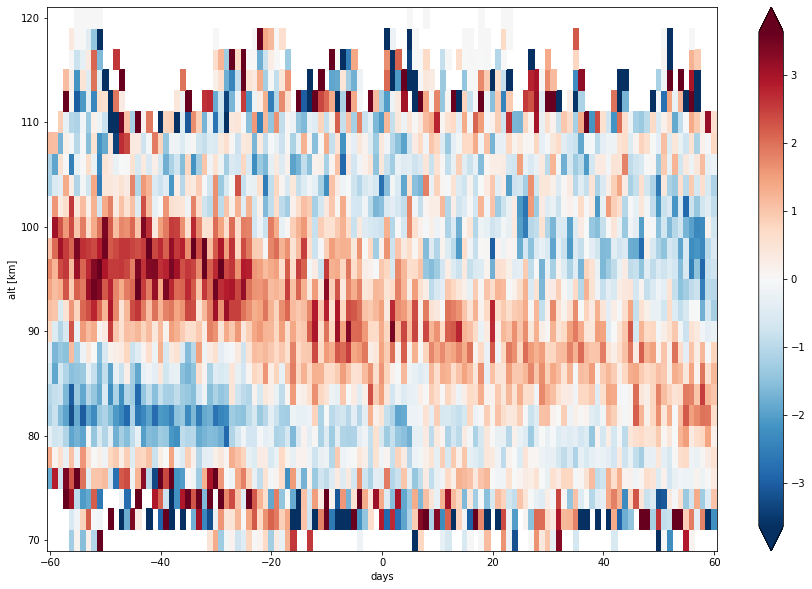

In [61]:
ax28 = sea_gw_u_rio_anomalie.plot(x="days", size=10, robust=True)
ax28.figure.savefig("graphics/gw_u_anomaly_rio.png")

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


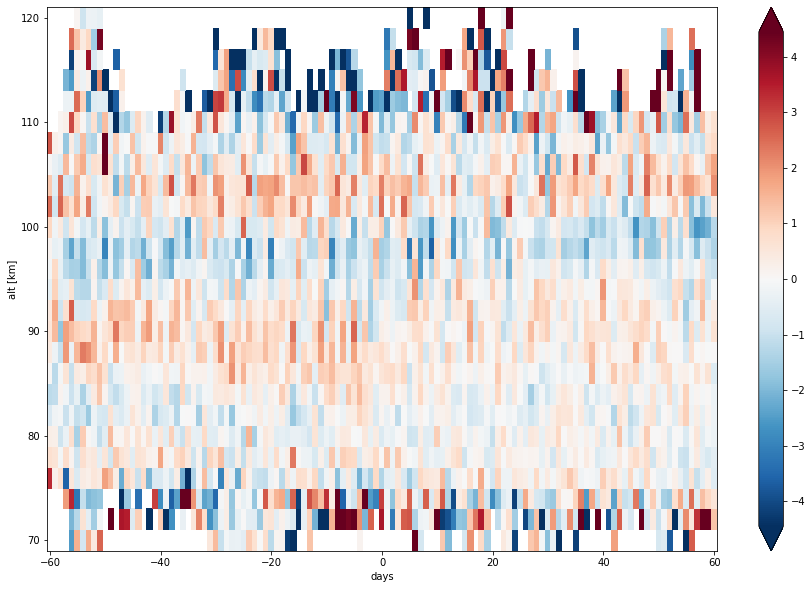

In [62]:
ax29 = sea_gw_v_rio.plot(x="days", size=10, robust=True)
ax29.figure.savefig("graphics/gw_v_clima_rio.png")

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


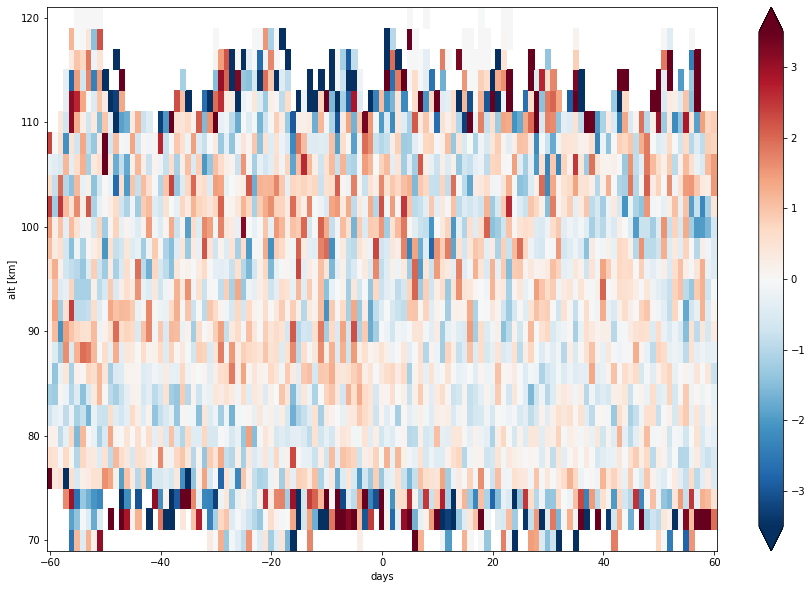

In [63]:
ax30 = sea_gw_v_rio_anomalie.plot(x="days", size=10, robust=True)
ax30.figure.savefig("graphics/gw_v_anomaly_rio.png")

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


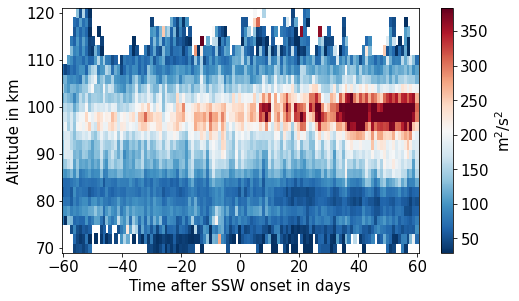

In [24]:
ax31 = sea_gw_total_energy_rio.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax31)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax31.figure.savefig("graphics/gw_total_energy_rio_small.png", bbox_inches="tight")
ax31.figure.savefig("graphics/gw_total_energy_rio_small.eps", bbox_inches="tight")

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


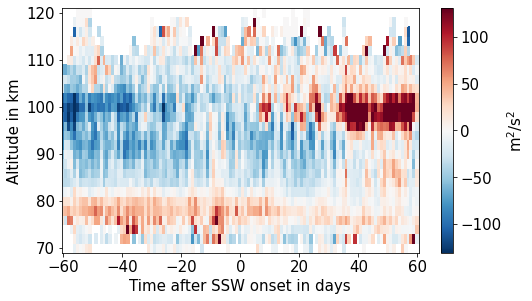

In [25]:
ax32 = sea_gw_total_energy_rio_anomalie.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax32)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax32.figure.savefig(
    "graphics/gw_total_energy_rio_anomaly_small.png", bbox_inches="tight"
)
ax32.figure.savefig(
    "graphics/gw_total_energy_rio_anomaly_small.eps", bbox_inches="tight"
)

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [26]:
gw_total_energy_cma = kin_energy_grav_waves("CMA")

sea_gw_total_energy_cma = sea(60, "CMA", gw_total_energy_cma)


gw_total_energy_cma_anomalie = anomalie("day", gw_total_energy_cma)

sea_gw_total_energy_cma_anomalie = sea(60, "CMA", gw_total_energy_cma_anomalie)


gw_u_cma = grav_waves("u", "CMA")
gw_v_cma = grav_waves("v", "CMA")

sea_gw_u_cma = sea(60, "CMA", gw_u_cma)
sea_gw_v_cma = sea(60, "CMA", gw_v_cma)

gw_u_cma_anomalie = anomalie("day", gw_u_cma)
gw_v_cma_anomalie = anomalie("day", gw_v_cma)

sea_gw_u_cma_anomalie = sea(60, "CMA", gw_u_cma_anomalie)
sea_gw_v_cma_anomalie = sea(60, "CMA", gw_v_cma_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


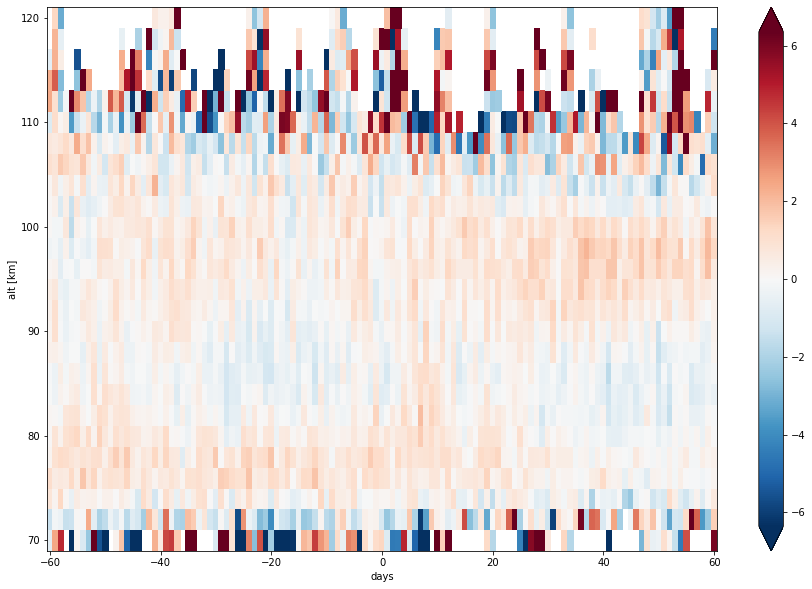

In [67]:
ax33 = sea_gw_u_cma.plot(x="days", size=10, robust=True)
ax33.figure.savefig("graphics/gw_u_clima_cma.png")

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


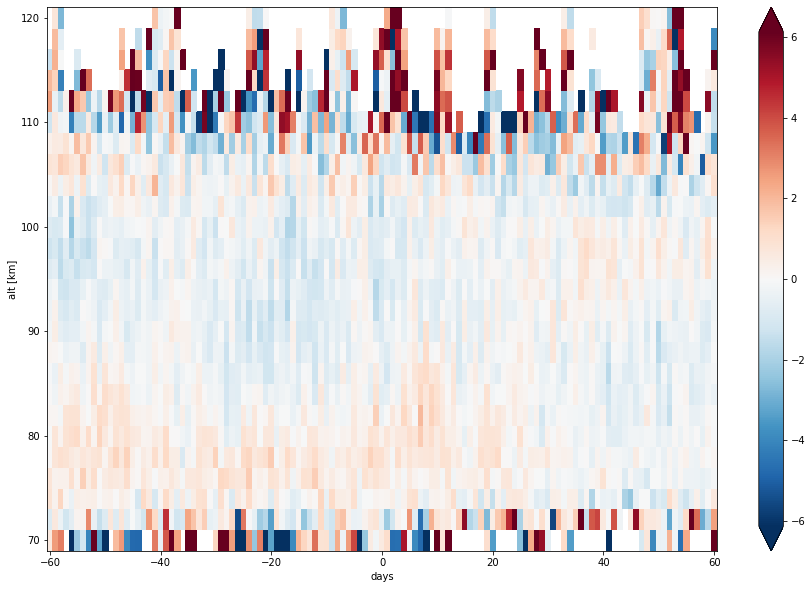

In [68]:
ax34 = sea_gw_u_cma_anomalie.plot(x="days", size=10, robust=True)
ax34.figure.savefig("graphics/gw_u_anomaly_cma.png")

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


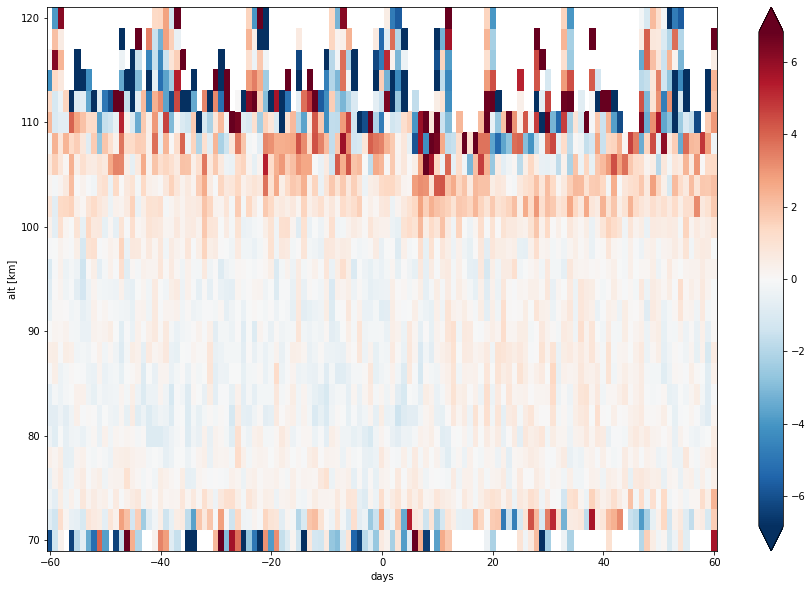

In [69]:
ax35 = sea_gw_v_cma.plot(x="days", size=10, robust=True)
ax35.figure.savefig("graphics/gw_v_clima_cma.png")

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


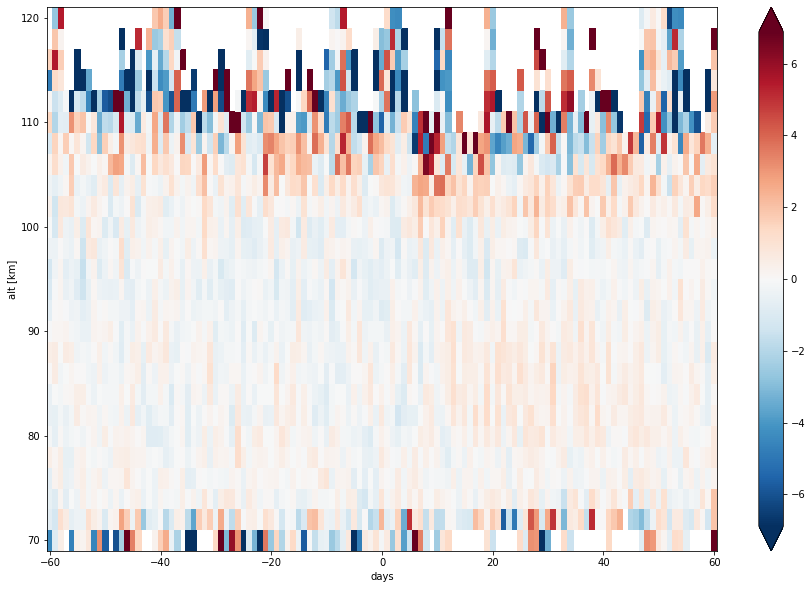

In [70]:
ax36 = sea_gw_v_cma_anomalie.plot(x="days", size=10, robust=True)
ax36.figure.savefig("graphics/gw_v_anomaly_cma.png")

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


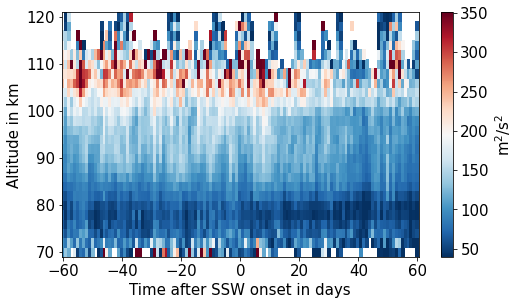

In [27]:
ax37 = sea_gw_total_energy_cma.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax37)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax37.figure.savefig("graphics/gw_total_energy_cma_small.png", bbox_inches="tight")
ax37.figure.savefig("graphics/gw_total_energy_cma_small.eps", bbox_inches="tight")

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


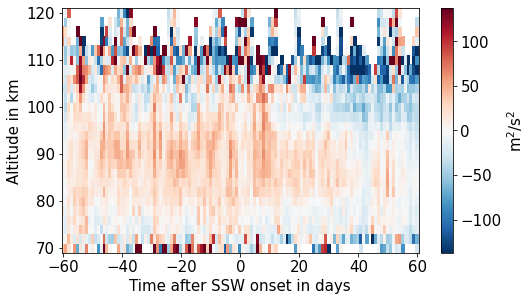

In [28]:
ax38 = sea_gw_total_energy_cma_anomalie.plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax38)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax38.figure.savefig(
    "graphics/gw_total_energy_cma_anomaly_small.png", bbox_inches="tight"
)
ax38.figure.savefig(
    "graphics/gw_total_energy_cma_anomaly_small.eps", bbox_inches="tight"
)

##### Interpretation

As we don't see any significant signature either in the u- or v-component or in the total kinetic energy of the gravity waves around the SSW onset, the by the meteor radar observed more easterly (westward) zonal winds in altitutes from around 90 to 110 km and the fluctuations in the meridional wind component seem not to be caused by gravity waves. Which leads us to the assumption, that this features could be induced by planetary wave activity which were not considered in this study.

#### Davis (Antarctic)

In [18]:
gw_total_energy_dav = kin_energy_grav_waves("Dav")

sea_gw_total_energy_dav = sea(60, "Dav", gw_total_energy_dav)


gw_total_energy_dav_anomalie = anomalie("day", gw_total_energy_dav)

sea_gw_total_energy_dav_anomalie = sea(60, "Rio", gw_total_energy_dav_anomalie)


gw_u_dav = grav_waves("u", "Dav")
gw_v_dav = grav_waves("v", "Dav")

sea_gw_u_dav = sea(60, "Dav", gw_u_dav)
sea_gw_v_dav = sea(60, "Dav", gw_v_dav)

gw_u_dav_anomalie = anomalie("day", gw_u_dav)
gw_v_dav_anomalie = anomalie("day", gw_v_dav)

sea_gw_u_dav_anomalie = sea(60, "Dav", gw_u_dav_anomalie)
sea_gw_v_dav_anomalie = sea(60, "Dav", gw_v_dav_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


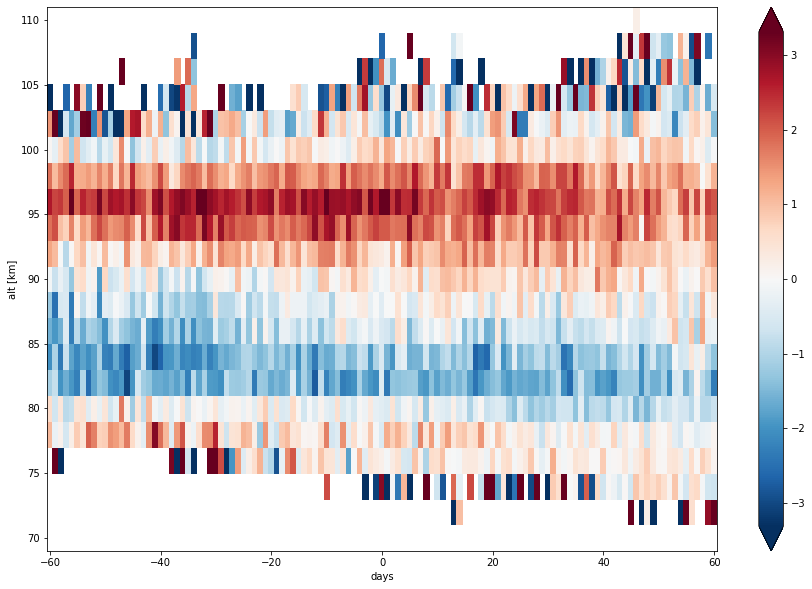

In [74]:
ax39 = sea_gw_u_dav.sel(alt=slice(70, 110)).plot(x="days", size=10, robust=True)
ax39.figure.savefig("graphics/gw_u_clima_dav.png")

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


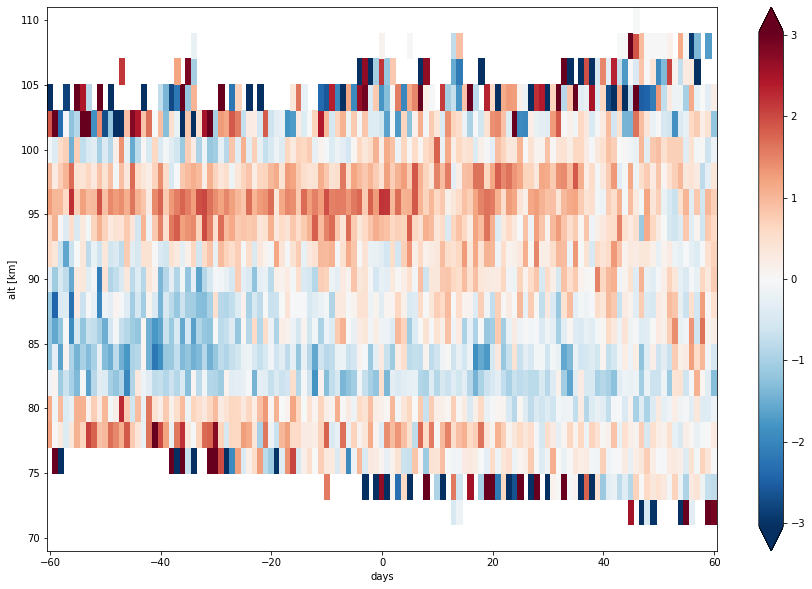

In [75]:
ax40 = sea_gw_u_dav_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", size=10, robust=True
)
ax40.figure.savefig("graphics/gw_u_anomaly_dav.png")

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


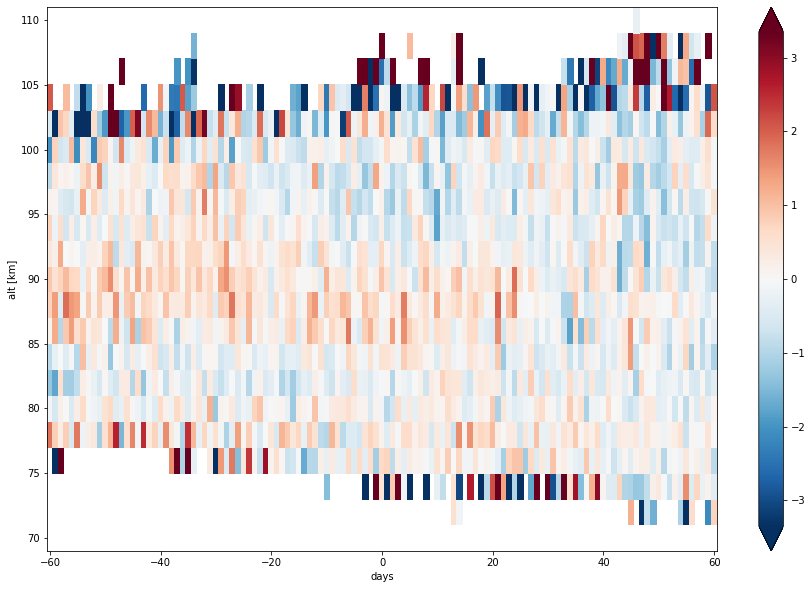

In [76]:
ax41 = sea_gw_v_dav.sel(alt=slice(70, 110)).plot(x="days", size=10, robust=True)
ax41.figure.savefig("graphics/gw_v_clima_dav.png")

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


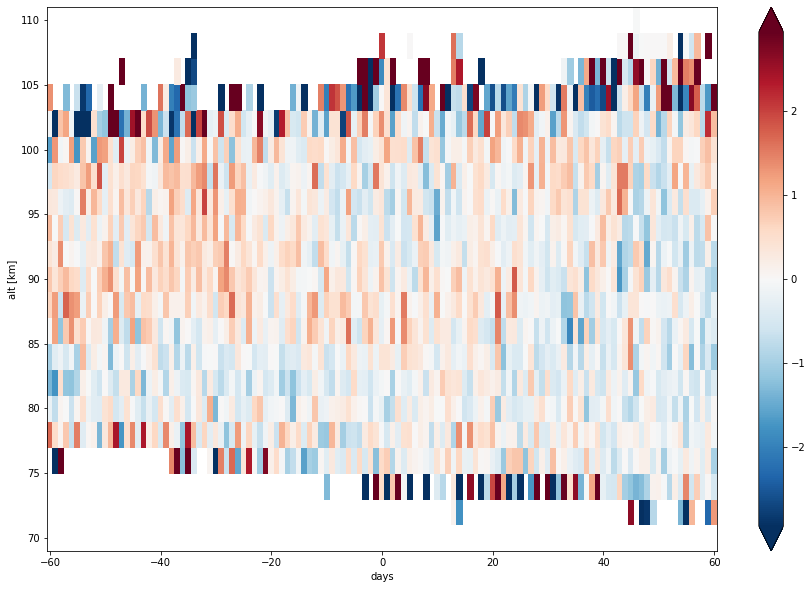

In [77]:
ax42 = sea_gw_v_dav_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", size=10, robust=True
)
ax42.figure.savefig("graphics/gw_v_anomaly_dav.png")

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


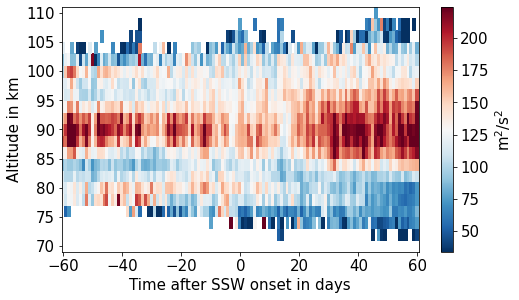

In [19]:
ax43 = sea_gw_total_energy_dav.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax43)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax43.figure.savefig("graphics/gw_total_energy_dav_small.png", bbox_inches="tight")
ax43.figure.savefig("graphics/gw_total_energy_dav_small.eps", bbox_inches="tight")

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


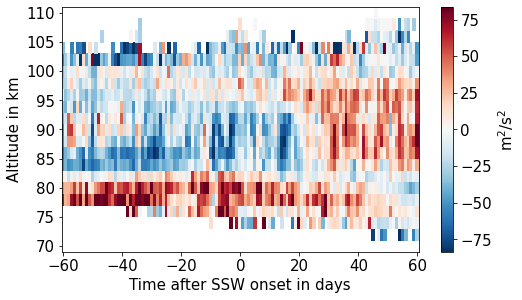

In [20]:
ax44 = sea_gw_total_energy_dav_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax44)
cb.set_label(label=f"m$^{2}$/s$^{2}$", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax44.figure.savefig(
    "graphics/gw_total_energy_dav_anomaly_small.png", bbox_inches="tight"
)
ax44.figure.savefig(
    "graphics/gw_total_energy_dav_anomaly_small.eps", bbox_inches="tight"
)

#### Kiruna, Norrbotten (Sweden)

In [80]:
gw_total_energy_kir = kin_energy_grav_waves("Kir")

sea_gw_total_energy_kir = sea(60, "Kir", gw_total_energy_kir)


gw_total_energy_kir_anomalie = anomalie("day", gw_total_energy_kir)

sea_gw_total_energy_kir_anomalie = sea(60, "Kir", gw_total_energy_kir_anomalie)


gw_u_kir = grav_waves("u", "Kir")
gw_v_kir = grav_waves("v", "Kir")

sea_gw_u_kir = sea(60, "Kir", gw_u_kir)
sea_gw_v_kir = sea(60, "Kir", gw_v_kir)

gw_u_kir_anomalie = anomalie("day", gw_u_kir)
gw_v_kir_anomalie = anomalie("day", gw_v_kir)

sea_gw_u_kir_anomalie = sea(60, "Kir", gw_u_kir_anomalie)
sea_gw_v_kir_anomalie = sea(60, "Kir", gw_v_kir_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


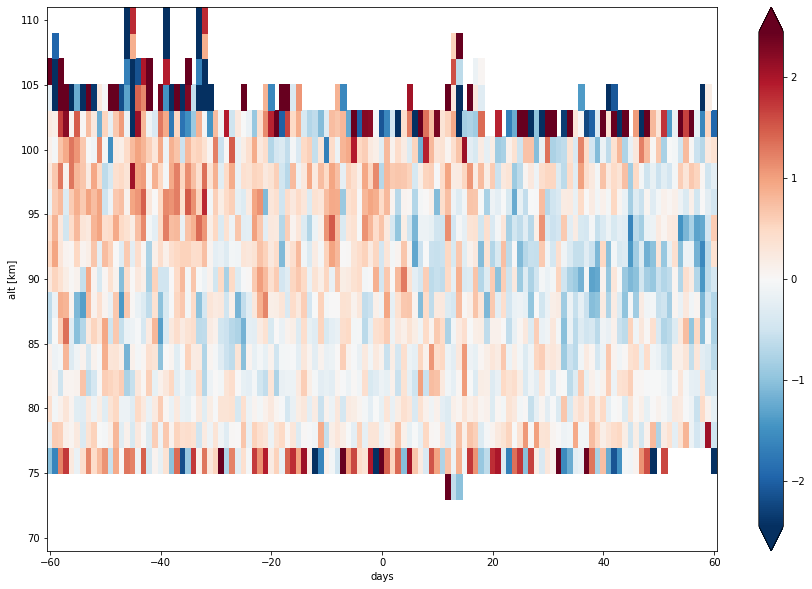

In [81]:
ax45 = sea_gw_u_kir.sel(alt=slice(70, 110)).plot(x="days", size=10, robust=True)
ax45.figure.savefig("graphics/gw_u_clima_kir.png")

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


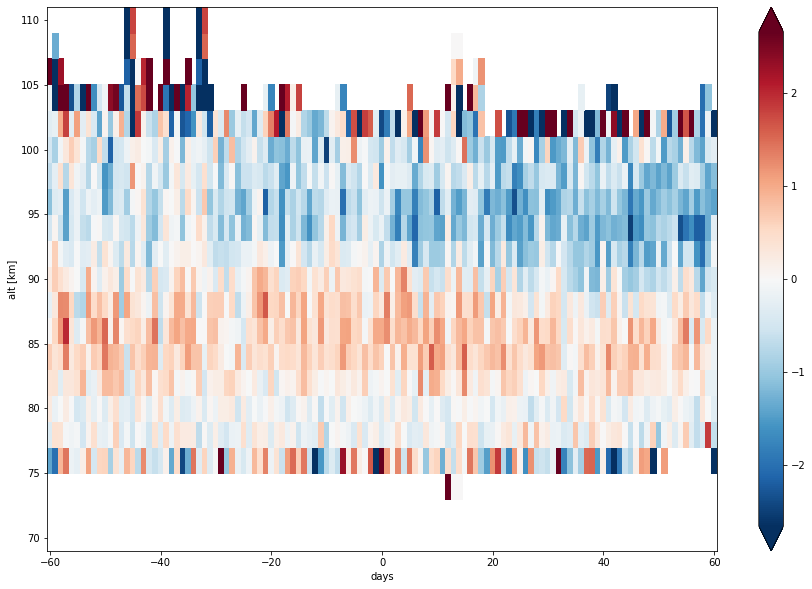

In [82]:
ax46 = sea_gw_u_kir_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", size=10, robust=True
)
ax46.figure.savefig("graphics/gw_u_anomaly_kir.png")

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


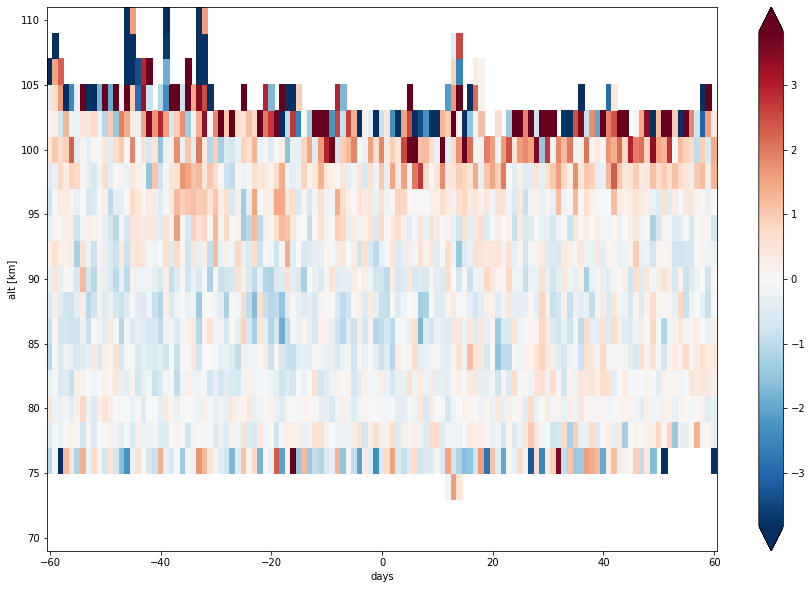

In [83]:
ax47 = sea_gw_v_kir.sel(alt=slice(70, 110)).plot(x="days", size=10, robust=True)
ax47.figure.savefig("graphics/gw_v_clima_kir.png")

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


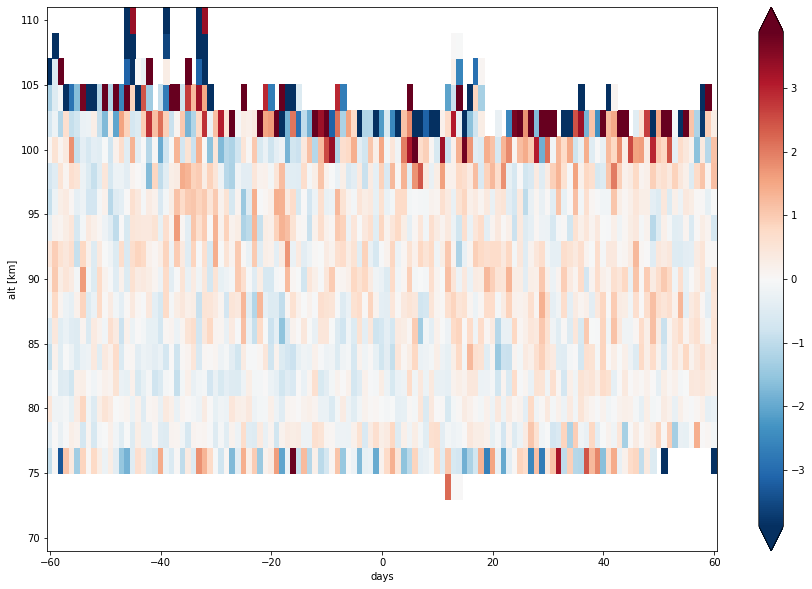

In [84]:
ax48 = sea_gw_v_kir_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", size=10, robust=True
)
ax48.figure.savefig("graphics/gw_v_anomaly_kir.png")

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


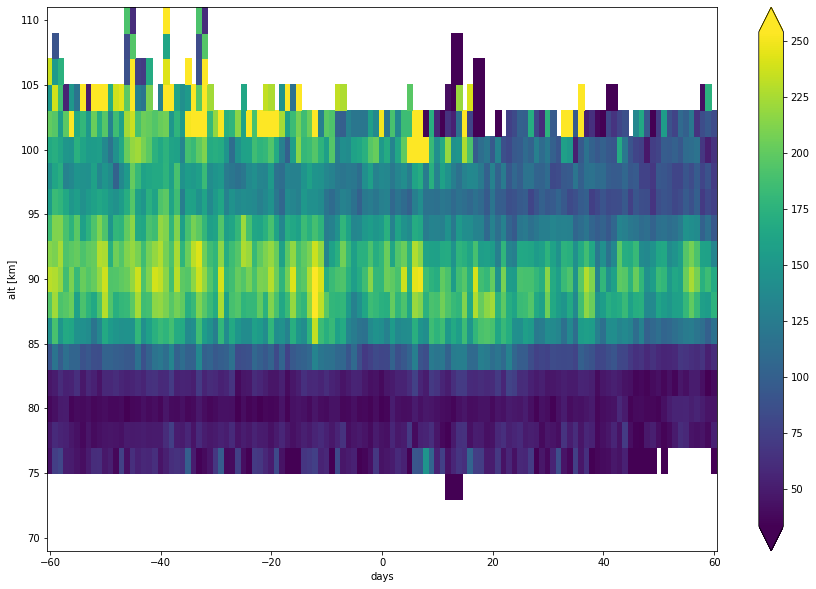

In [85]:
ax49 = sea_gw_total_energy_kir.sel(alt=slice(70, 110)).plot(
    x="days", size=10, robust=True
)
ax49.figure.savefig("graphics/gw_tot_clima_kir.png")

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


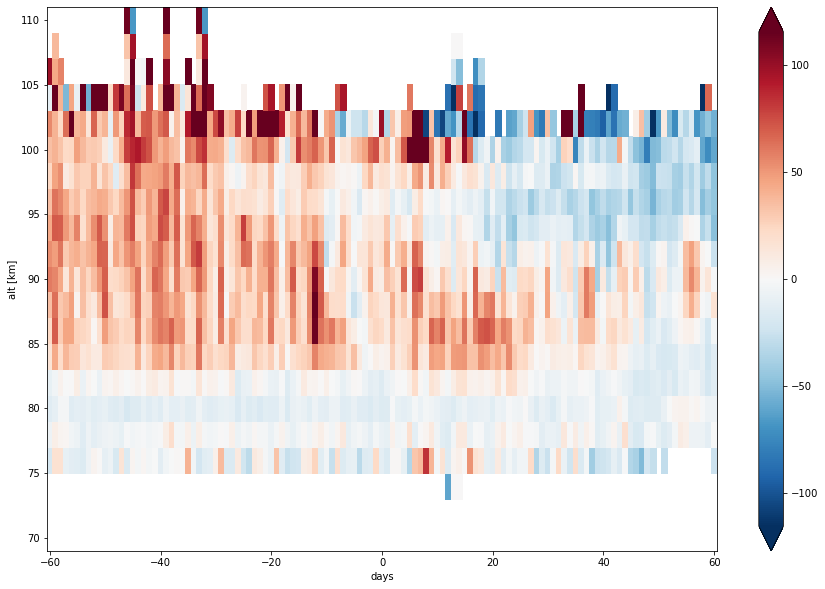

In [86]:
ax50 = sea_gw_total_energy_kir_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", size=10, robust=True
)
ax50.figure.savefig("graphics/gw_tot_anomaly_kir.png")

#### Interpretation

Concerning the gravity waves we see a different behaviour for both hemispheres. The meteor radars on the northern hemisphere (Collm, Kiruna, CMA) show an increased level of gravity wave kinetic energy before and around - maybe short time after, too - the onset of the SSW's. Later the activity of gravity waves reduces to the normal climatological amount.

On the southern hemisphere (RioGrande, Davis) this is vice-versa. Before the SSW-onset gravity waves are at a low level. Approximately 2 to 3 weeks afterwards the kinetic energy is significantly increased compared to the climatological mean.

The reason for the enhanced level of gravity wave kinetic energy on the northern hemisphere before the SSW onset could be the jetstream, which intensifies typically before the beginning of a SSW event (was already shown with GAIA model data of zonal wind speed --> see chapter ?). Because of the increased wind speed the gravity wave filtering is changed in that way, that more waves with larger positive phase speeds are filtered and can't propagate further upward to the mesosphere. As a result there are less gravity waves with positive phase speed in the mesosphere. Because of that the gravity waves with negative phase speed predominate even more than normal. Thus the zonal gravity wave component (which is defined as the difference between the positive and negative zonal gravity wave components) becomes absolute more negative (according to amount greater). Hence the total kinetic energy of gravity waves increases (refer to the definition formula of E_kin_tot_gw!!!). This leads to the observed enhanced gravity wave activity in higher altitudes (here: 85-95 km).

The structures on the Southern Hemisphere are caused by the so-called "inter-hemispheric coupling". Maybe look for that in literature or simply say it was not investigated in this project.

##### Inter-hemispheric coupling

During an SSW event the (eastward) zonal wind decreases (shown before). On the one hand this leads to a Dopler-shifting of the westward propagating gravity waves (negative phase speeds) towards shorter vertical wavelengths. As a result they break at lower altitudes. On the other hand, gw's with high positive phase speeds can propagate further upward into the mesosphere as they are not filtered any more. Because of these processes the westward gravity wave drag is both reduced and downward shifted in the winter mesosphere [Körnich and Becker, 2010]. Thus the poleward meridional flow on the NH weakens, in the following the polar mesosphere is cooling, the tropical mesosphere is warming. Because of the warmer tropical mesosphere the latitudinal gradient in the mesosphere of the summer hemisphere (southern hemisphere) is weakened. In order to fulfill the thermal wind balance the zonal wind (westward) on the SH has to weaken as well. Therefore gravity waves on the SH break at lower altitudes and the gravity wave drag/force in the upper mesosphere is reduced [Yasui et al., 2016].

This means: According to the theory, GW activity in the upper mesosphere should reduce in the time after an SSW (with 4-10 days shift). Below it should increase. One should also observe a negative anomaly of the mean meridional wind [Yasui et al., 2016].

Our findings according to anomalies of GWs kinetic energy (KE) in Davis and Rio Grande seem to be consistent with the theoretical expectation. We can see negative anomalies before or around SSWs around 90 km and positive anomalies below. And in the climatology plot we see the decreasing kinetic energy of gw around the SSW onset as well. 

At Rio Grande we also find the expected negative anomalies in the meridional wind component around the second week after the SSW onset. At Davis this is not well pronounced.

When to explain inter-hemispheric coupling? --> maybe in the basics section as well...

## GAIA data

### General definitions

In [18]:
root_path = "/home/gemeinsam_tmp/UA_students/data/"
fname = ""

In [19]:
def read_gaia_group(gruppe, loc):

    if loc == "Rio":
        timestart = "2008-02-01"
        timeend = "2019-12-31"
        fname = "GAIA_Rio_20080201_20141231_run20200603.nc"

    elif loc == "Col":
        timestart = "2004-08-01"
        timeend = "2017-12-31"
        fname = "GAIA_Col_20040801_20171231_run20200604.nc"

    elif loc == "CMA":
        timestart = "2002-01-01"
        timeend = "2018-12-31"
        fname = "GAIA_CMA_20020101_20171231_run20200531.nc"
    elif loc == "Kir":
        timestart = "1999-08-01"
        timeend = "2017-12-31"
        fname = "GAIA_Kir_19990801_20171231_run20200605.nc"
    elif loc == "Dav":
        timestart = "2005-01-01"
        timeend = "2017-12-31"
        fname = "GAIA_Dav_20050101_20171231_run20200604.nc"

    infile = f"{root_path}{fname}"
    ds = xr.open_dataset(infile, group=gruppe)
    ds["time"] = pd.date_range(start=timestart, end=timeend, periods=ds.time.shape[0])
    ds = ds.chunk({"alt": 12})
    return ds

### Wind model data analysis

#### Collm

In [23]:
ds_col_gaia = read_gaia_group("GAIA", "Col")
print(ds_col_gaia)

u_col_gaia = read_var(ds_col_gaia, "u")
v_col_gaia = read_var(ds_col_gaia, "v")

u_col_gaia_anomalie = anomalie("hour", u_col_gaia)
# u_col_anomalie.plot(x='time',robust=True)

v_col_gaia_anomalie = anomalie("day", v_col_gaia)

sea_u_col_gaia = sea(30, "Col", u_col_gaia)
sea_u_col_gaia_anomalie = sea(30, "Col", u_col_gaia_anomalie)

sea_v_col_gaia = sea(30, "Col", v_col_gaia)
sea_v_col_gaia_anomalie = sea(30, "Col", v_col_gaia_anomalie)

<xarray.Dataset>
Dimensions:    (alt: 93, time: 117624)
Coordinates:
  * alt        (alt) float64 16.0 18.0 20.0 22.0 ... 340.0 360.0 380.0 400.0
  * time       (time) datetime64[ns] 2004-08-01 ... 2017-12-31
Data variables:
    u          (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    v          (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    w          (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    u_err      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    v_err      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    w_err      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    temp       (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    temp_err   (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    u_fil      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.n

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 4901 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]


##### Climatology of u-component

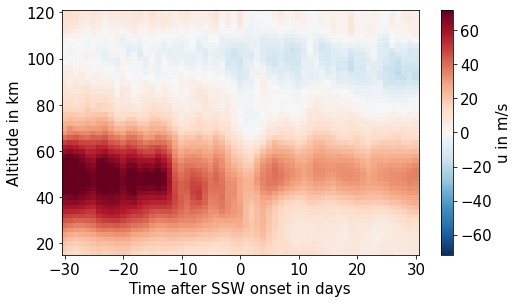

In [24]:
ax51 = sea_u_col_gaia.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax51)
cb.set_label(label="u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax51.figure.savefig("graphics/u_clima_col_gaia_small.png", bbox_inches="tight")
ax51.figure.savefig("graphics/u_clima_col_gaia_small.eps", bbox_inches="tight")

##### Anomalies of u-component

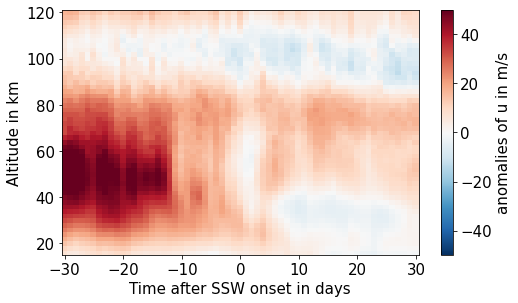

In [25]:
ax52 = sea_u_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax52)
cb.set_label(label="anomalies of u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax52.figure.savefig("graphics/u_anomaly_col_gaia_small.png", bbox_inches="tight")
ax52.figure.savefig("graphics/u_anomaly_col_gaia_small.eps", bbox_inches="tight")

##### Interpretation

The GAIA model simulations for the u-component of the wind show an anomalously high intensity of the polar stratospheric jet stream (~50 km altitude) in the month before the SSW onsets. The anomalies of the zonal wind speed show values of up to 50 m/s in comparison to the climatological mean values for the corresponding calendar day.

This zone of enhanced wind speed around the intensified stratospheric jet ranges with its edges from 30 km up to 80 km. Hence this could be the reason for the enhanced zonal wind speed in the Mesosphere, which was observed by the Collm Meteor radar in the month before the onsets of the SSWs (see chapter 1).

Ongoing from 10 days before the SSW onset the zonal wind gets less westerly (eastward) especially in an altitude range from 40 to 60 km (around the altitude of the stratospheric jet in 50 km) (until it reverses and shows even a slight easterly (westward component) in the days around the SSW onset.)
But even in the atmospheric layers between 60 and 80 km the zonal wind gets less westerly and at Kiruna also slightly reverses around the SSW onset. The reason therefore is the enhanced easterly (westward) gravity wave activity in the mesosphere, which is generated by the increased critical-layer filtering because of the intensified stratospheric jet stream (was shown before) in the month before the SSW onset. This westward gravity waves propagate up to the mesosphere and reach high amplitudes because of the exponentially decreasing density and break because of that. When they break they generate easterly (westward) winds, which (over-)compensate the normal westerly (eastward) flow. These easterlies move downward in time. 

In the month after the SSW onset the zone of anomalously low westerly (eastward) zonal winds descends in the middle and lower stratosphere (20-40 km). Above the westerly zonal winds are stronger than normal. This phenomenon refers to the so-called "elevated stratopause", which often re-establishes in altitudes of 60-80 km atfer an SSW event and descends gradually to normal altitudes afterwards.
Here GAIA agrees with the Collm Meteor Radar, which observed anomaously strong westerly winds in altitudes from 70-80 km as well.

As this feature can be seen in the SSW-climatologies as well of the Radar observations as of the GAIA simulations, it seems likely that an elevated stratopause (ES) event occurs often after an SSW event.

##### Climatology of v-component

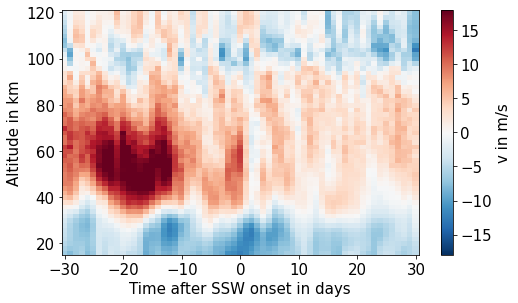

In [26]:
ax53 = sea_v_col_gaia.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax53)
cb.set_label(label="v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax53.figure.savefig("graphics/v_clima_col_gaia_small.png", bbox_inches="tight")
ax53.figure.savefig("graphics/v_clima_col_gaia_small.eps", bbox_inches="tight")

##### Anomalies of v-component

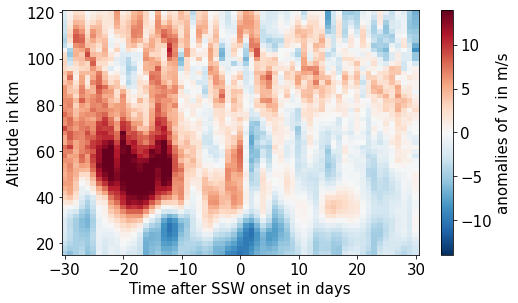

In [27]:
ax54 = sea_v_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax54)
cb.set_label(label="anomalies of v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax54.figure.savefig("graphics/v_anomaly_col_gaia_small.png", bbox_inches="tight")
ax54.figure.savefig("graphics/v_anomaly_col_gaia_small.eps", bbox_inches="tight")

##### Interpretation

The meridional wind reversal from southern (northward) to northern (southward) around the onset of the SSW events, which was observed by the Collm Meteor Radar, is reproduced by the GAIA model as well.

Another interesting feature is the strong increase of the southern (northward) winds in 40 - 70 km altitudes in the month before the SSW onset. As this phenomenon is even more pronounced in the model runs for the Kiruna station, it is explained later on in the corresponding section.

#### Rio

In [94]:
ds_rio_gaia = read_gaia_group("GAIA", "Rio")
# print(ds_rio_gaia)

u_rio_gaia = read_var(ds_rio_gaia, "u")
v_rio_gaia = read_var(ds_rio_gaia, "v")

u_rio_gaia_anomalie = anomalie("day", u_rio_gaia)

v_rio_gaia_anomalie = anomalie("day", v_rio_gaia)

sea_u_rio_gaia = sea(30, "Rio", u_rio_gaia)
sea_u_rio_gaia_anomalie = sea(30, "Rio", u_rio_gaia_anomalie)

sea_v_rio_gaia = sea(30, "Rio", v_rio_gaia)
sea_v_rio_gaia_anomalie = sea(30, "Rio", v_rio_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]


##### Climatology of u-component

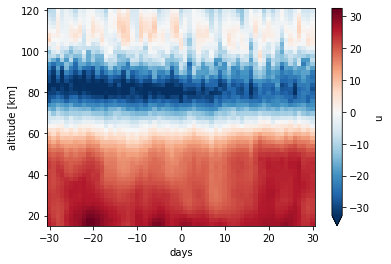

In [95]:
ax55 = sea_u_rio_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax55.figure.savefig("graphics/u_clima_rio_gaia.png")

##### Anomalies of u-component

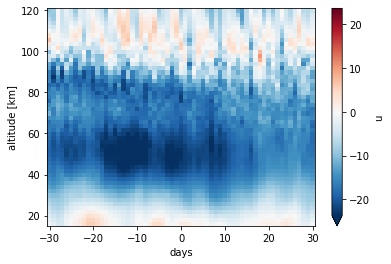

In [96]:
ax56 = sea_u_rio_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax56.figure.savefig("graphics/u_anomaly_rio_gaia.png")

##### Climatology of v-component

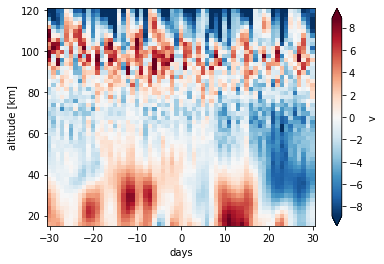

In [97]:
ax57 = sea_v_rio_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax57.figure.savefig("graphics/v_clima_rio_gaia.png")

##### Anomalies of v-component

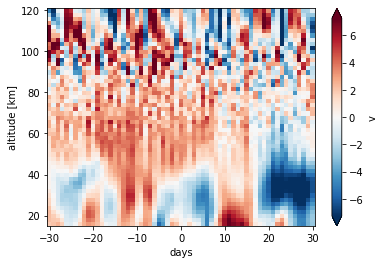

In [98]:
ax58 = sea_v_rio_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax58.figure.savefig("graphics/v_anomaly_rio_gaia.png")

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [99]:
ds_cma_gaia = read_gaia_group("GAIA", "CMA")
# print(ds_cma_gaia)

u_cma_gaia = read_var(ds_cma_gaia, "u")
v_cma_gaia = read_var(ds_cma_gaia, "v")

u_cma_gaia_anomalie = anomalie("day", u_cma_gaia)

v_cma_gaia_anomalie = anomalie("day", v_cma_gaia)

sea_u_cma_gaia = sea(30, "CMA", u_cma_gaia)
sea_u_cma_gaia_anomalie = sea(30, "CMA", u_cma_gaia_anomalie)

sea_v_cma_gaia = sea(30, "CMA", v_cma_gaia)
sea_v_cma_gaia_anomalie = sea(30, "CMA", v_cma_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]


##### Climatology of u-component

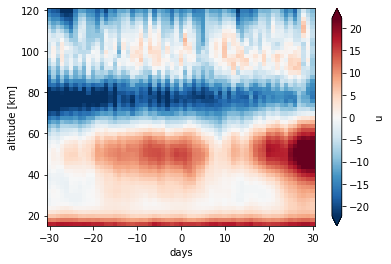

In [100]:
ax59 = sea_u_cma_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax59.figure.savefig("graphics/u_clima_cma_gaia.png")

##### Anomalies of u-component

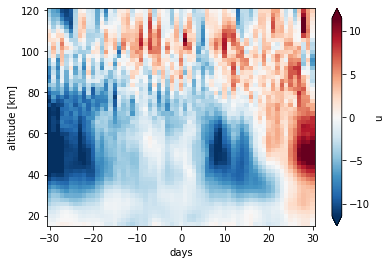

In [101]:
ax60 = sea_u_cma_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax60.figure.savefig("graphics/u_anomaly_cma_gaia.png")

##### Climatology of v-component

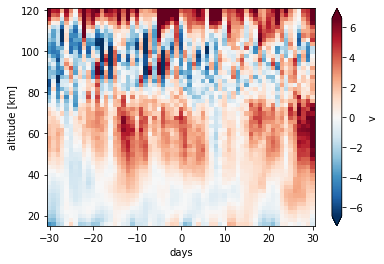

In [102]:
ax61 = sea_v_cma_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax61.figure.savefig("graphics/v_clima_cma_gaia.png")

##### Anomalies of v-component

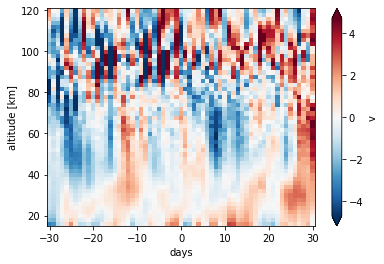

In [103]:
ax62 = sea_v_cma_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax62.figure.savefig("graphics/v_anomaly_cma_gaia.png")

#### Davis (Antarctic)

In [104]:
ds_dav_gaia = read_gaia_group("GAIA", "Dav")
# print(ds_dav_gaia)

u_dav_gaia = read_var(ds_dav_gaia, "u")
v_dav_gaia = read_var(ds_dav_gaia, "v")

u_dav_gaia_anomalie = anomalie("day", u_dav_gaia)

v_dav_gaia_anomalie = anomalie("day", v_dav_gaia)

sea_u_dav_gaia = sea(30, "Dav", u_dav_gaia)
sea_u_dav_gaia_anomalie = sea(30, "Dav", u_dav_gaia_anomalie)

sea_v_dav_gaia = sea(30, "Dav", v_dav_gaia)
sea_v_dav_gaia_anomalie = sea(30, "Dav", v_dav_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]


##### Climatology of u-component

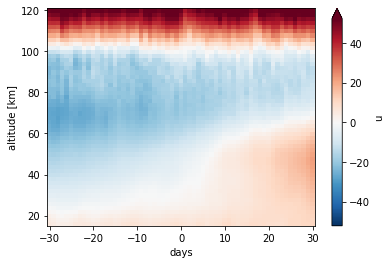

In [105]:
ax63 = sea_u_dav_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax63.figure.savefig("graphics/u_clima_dav_gaia.png")

##### Anomalies of u-component

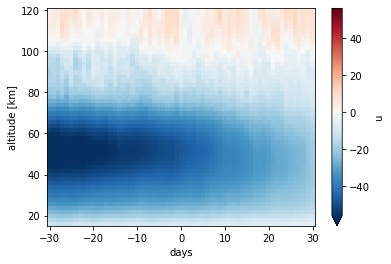

In [106]:
ax64 = sea_u_dav_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax64.figure.savefig("graphics/u_anomaly_dav_gaia.png")

##### Climatology of v-component

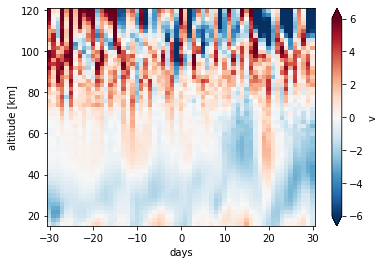

In [107]:
ax65 = sea_v_dav_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax65.figure.savefig("graphics/v_clima_dav_gaia.png")

##### Anomalies of v-component

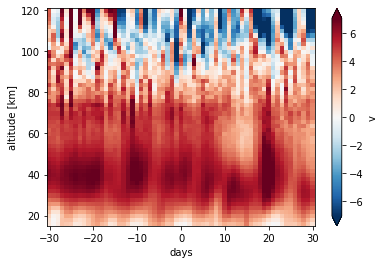

In [108]:
ax66 = sea_v_dav_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)
ax66.figure.savefig("graphics/v_anomaly_dav_gaia.png")

#### Kiruna, Norrbotten (Sweden)

In [20]:
ds_kir_gaia = read_gaia_group("GAIA", "Kir")
# print(ds_kir_gaia)

u_kir_gaia = read_var(ds_kir_gaia, "u")
v_kir_gaia = read_var(ds_kir_gaia, "v")

u_kir_gaia_anomalie = anomalie("day", u_kir_gaia)

v_kir_gaia_anomalie = anomalie("day", v_kir_gaia)

sea_u_kir_gaia = sea(30, "Kir", u_kir_gaia)
sea_u_kir_gaia_anomalie = sea(30, "Kir", u_kir_gaia_anomalie)

sea_v_kir_gaia = sea(30, "Kir", v_kir_gaia)
sea_v_kir_gaia_anomalie = sea(30, "Kir", v_kir_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]


##### Climatology of u-component

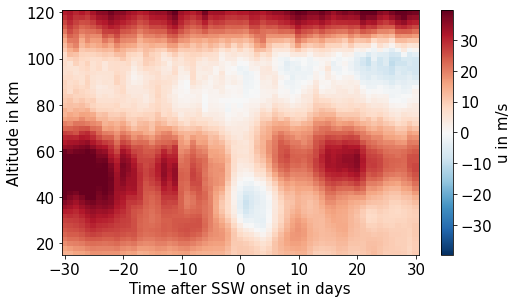

In [21]:
ax67 = sea_u_kir_gaia.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax67)
cb.set_label(label="u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax67.figure.savefig("graphics/u_clima_kir_gaia_small.png", bbox_inches="tight")
ax67.figure.savefig("graphics/u_clima_kir_gaia_small.eps", bbox_inches="tight")

##### Anomalies of u-component

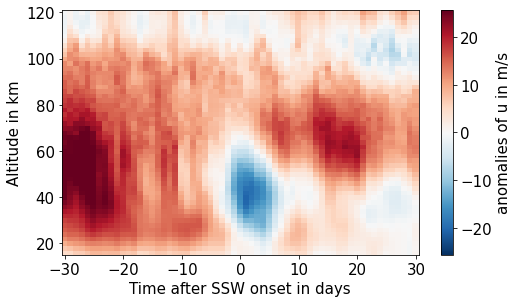

In [22]:
ax68 = sea_u_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax68)
cb.set_label(label="anomalies of u in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax68.figure.savefig("graphics/u_anomaly_kir_gaia_small.png", bbox_inches="tight")
ax68.figure.savefig("graphics/u_anomaly_kir_gaia_small.eps", bbox_inches="tight")

##### Climatology of v-component

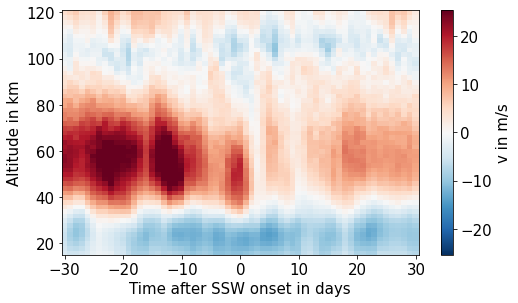

In [23]:
ax69 = sea_v_kir_gaia.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax69)
cb.set_label(label="v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax69.figure.savefig("graphics/v_clima_kir_gaia_small.png", bbox_inches="tight")
ax69.figure.savefig("graphics/v_clima_kir_gaia_small.eps", bbox_inches="tight")

##### Anomalies of v-component

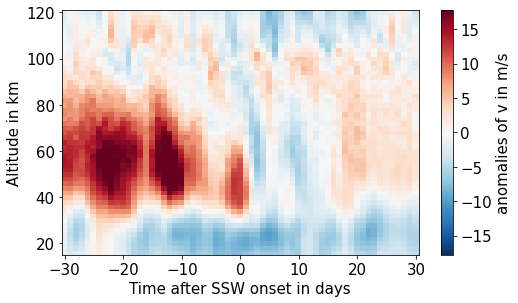

In [24]:
ax70 = sea_v_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, figsize=[8, 4.5], add_colorbar=False, cmap=cmap
)
plt.xticks(fontsize=fosi)
plt.yticks(fontsize=fosi)
plt.xlabel("Time after SSW onset in days", fontsize=fosi)
plt.ylabel("Altitude in km", fontsize=fosi)
cb = plt.colorbar(ax70)
cb.set_label(label="anomalies of v in m/s", fontsize=fosi)
cb.ax.tick_params(labelsize=fosi)

ax70.figure.savefig("graphics/v_anomaly_kir_gaia_small.png", bbox_inches="tight")
ax70.figure.savefig("graphics/v_anomaly_kir_gaia_small.eps", bbox_inches="tight")

##### Interpretation

The meridional wind reversal from southern (northward) to northern (southward) around the onset of the SSW events, which was observed by the Kiruna Meteor Radar, is reproduced by the GAIA model as well.

Another interesting feature is the strong increase of the southern (northward) winds in 40 - 70 km altitudes in the month before the SSW onset. This phenomenon is even more pronounced in the model runs for the Kiruna station here than it was in the runs for the Collm station.

The reason for this is again the increased critical layer filtering of gravity waves with positive phase speeds in the stratosphere due to the intensified stratospheric jet before the SSW onset. As less positive gravity waves can propagate upward into the mesosphere, more gravity waves with negative phase speeds (which are not filtered) remain in the mesosphere and dominate. These gravity waves with negative phase speeds induce a northward meridional transport. Subsequently we get an enhanced northward meridional transport in the month before the SSW onset, how it can be seen in the GAIA simulations for the Kiruna and Collm stations.

### Gravity waves model data analysis

#### Collm

In [114]:
gw_u_col_gaia = grav_waves_gaia("u", ds_col_gaia)
gw_v_col_gaia = grav_waves_gaia("v", ds_col_gaia)
gw_total_energy_col_gaia = kin_energy_grav_waves_gaia(ds_col_gaia)

sea_gw_u_col_gaia = sea(60, "Col", gw_u_col_gaia)
sea_gw_v_col_gaia = sea(60, "Col", gw_v_col_gaia)
sea_gw_total_energy_col_gaia = sea(60, "Col", gw_total_energy_col_gaia)


gw_total_energy_col_gaia_anomalie = anomalie("day", gw_total_energy_col_gaia)
gw_u_col_gaia_anomalie = anomalie("day", gw_u_col_gaia)
gw_v_col_gaia_anomalie = anomalie("day", gw_v_col_gaia)

sea_gw_total_energy_col_gaia_anomalie = sea(
    60, "Col", gw_total_energy_col_gaia_anomalie
)
sea_gw_u_col_gaia_anomalie = sea(60, "Col", gw_u_col_gaia_anomalie)
sea_gw_v_col_gaia_anomalie = sea(60, "Col", gw_v_col_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]


##### u-component of gravity waves

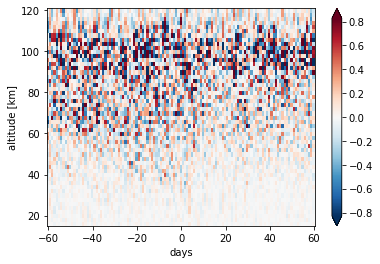

In [115]:
sea_gw_u_col_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the u-component of gravity waves

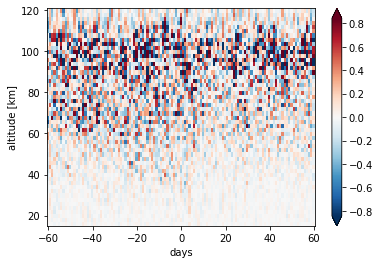

In [116]:
sea_gw_u_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### v-component of gravity waves

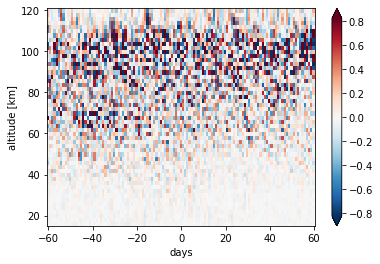

In [117]:
sea_gw_v_col_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the v-component of gravity waves

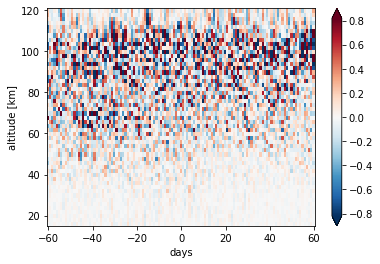

In [118]:
sea_gw_v_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Total kinetic energy of gravity waves

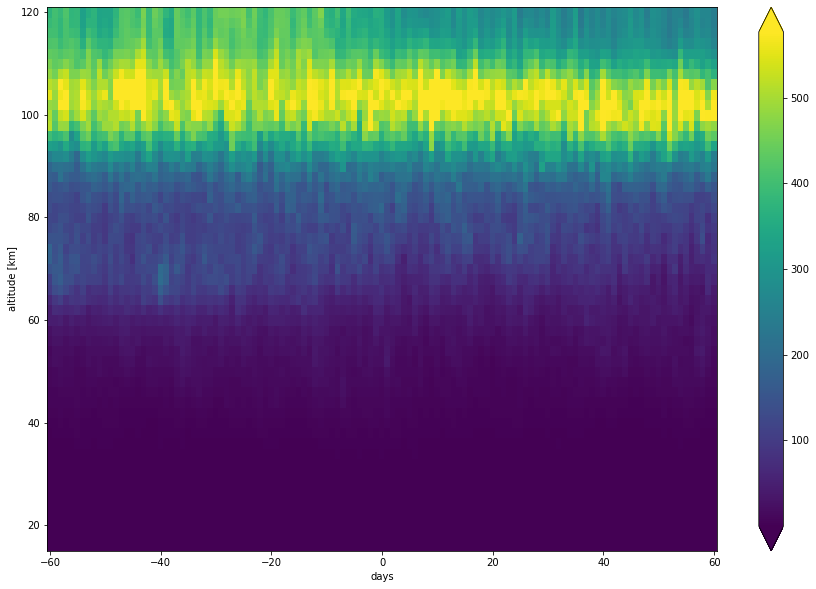

In [119]:
sea_gw_total_energy_col_gaia.sel(alt=slice(0, 120)).plot(x="days", size=10, robust=True)

##### Anomalies of the total kinetic energy of gravity waves

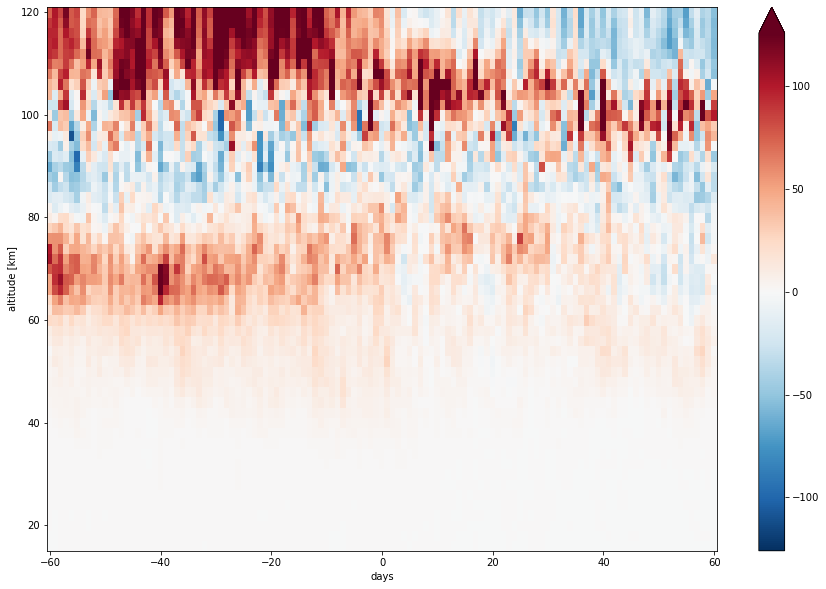

In [120]:
sea_gw_total_energy_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", size=10, robust=True
)

#### Rio

In [121]:
gw_u_rio_gaia = grav_waves_gaia("u", ds_rio_gaia)
gw_v_rio_gaia = grav_waves_gaia("v", ds_rio_gaia)
gw_total_energy_rio_gaia = kin_energy_grav_waves_gaia(ds_rio_gaia)

sea_gw_u_rio_gaia = sea(60, "Rio", gw_u_rio_gaia)
sea_gw_v_rio_gaia = sea(60, "Rio", gw_v_rio_gaia)
sea_gw_total_energy_rio_gaia = sea(60, "Rio", gw_total_energy_rio_gaia)


gw_total_energy_rio_gaia_anomalie = anomalie("day", gw_total_energy_rio_gaia)
gw_u_rio_gaia_anomalie = anomalie("day", gw_u_rio_gaia)
gw_v_rio_gaia_anomalie = anomalie("day", gw_v_rio_gaia)

sea_gw_total_energy_rio_gaia_anomalie = sea(
    60, "Rio", gw_total_energy_rio_gaia_anomalie
)
sea_gw_u_rio_gaia_anomalie = sea(60, "Rio", gw_u_rio_gaia_anomalie)
sea_gw_v_rio_gaia_anomalie = sea(60, "Rio", gw_v_rio_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]


##### u-component of gravity waves

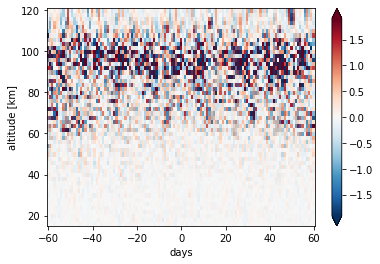

In [122]:
sea_gw_u_rio_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the u-component of gravity waves

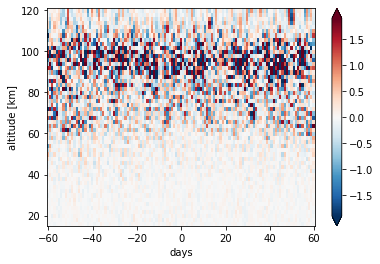

In [123]:
sea_gw_u_rio_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### v-component of gravity waves

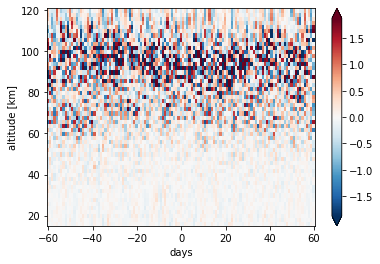

In [124]:
sea_gw_v_rio_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the v-component of gravity waves

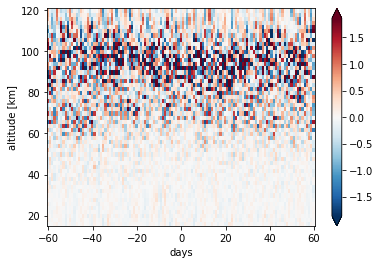

In [125]:
sea_gw_v_rio_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Total kinetic energy of gravity waves

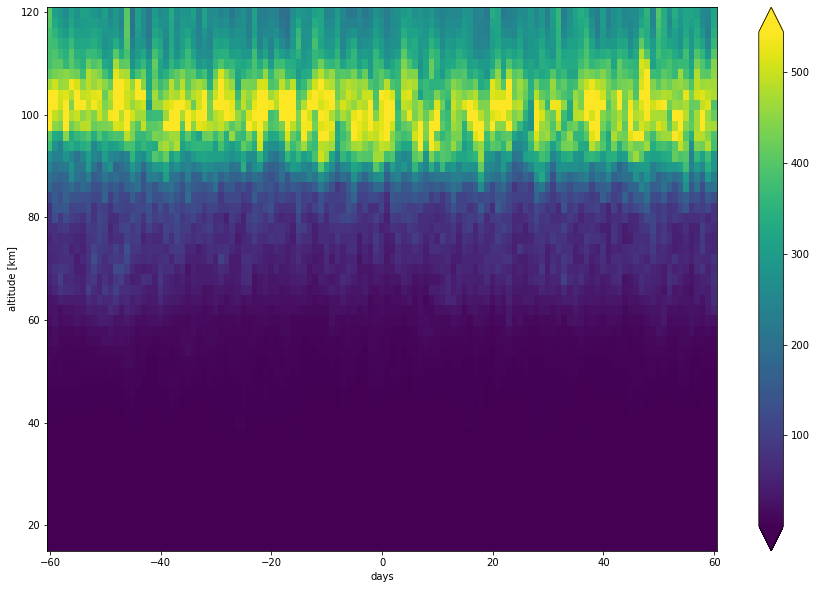

In [126]:
sea_gw_total_energy_rio_gaia.sel(alt=slice(0, 120)).plot(x="days", size=10, robust=True)

##### Anomalies of the total kinetic energy of gravity waves

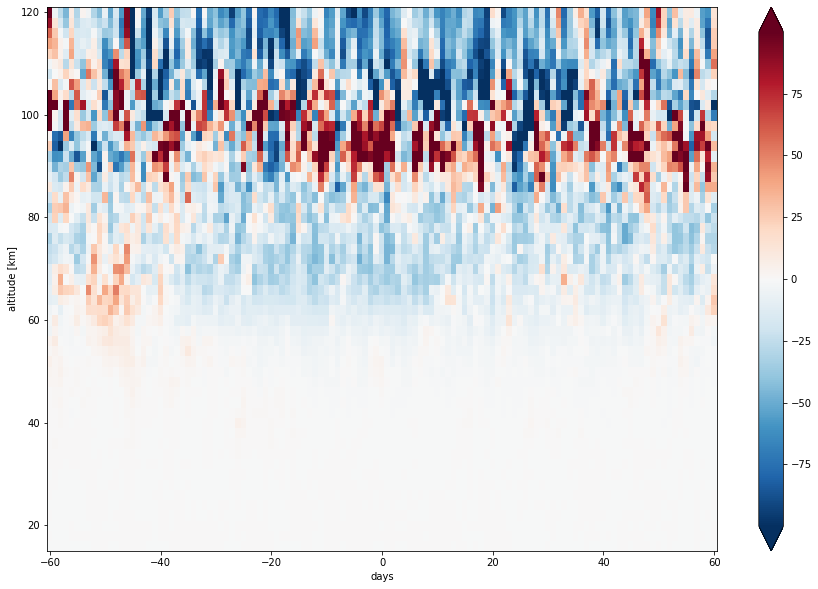

In [127]:
sea_gw_total_energy_rio_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", size=10, robust=True
)

#### CMA

In [128]:
gw_u_cma_gaia = grav_waves_gaia("u", ds_cma_gaia)
gw_v_cma_gaia = grav_waves_gaia("v", ds_cma_gaia)
gw_total_energy_cma_gaia = kin_energy_grav_waves_gaia(ds_cma_gaia)

sea_gw_u_cma_gaia = sea(60, "CMA", gw_u_cma_gaia)
sea_gw_v_cma_gaia = sea(60, "CMA", gw_v_cma_gaia)
sea_gw_total_energy_cma_gaia = sea(60, "CMA", gw_total_energy_cma_gaia)


gw_total_energy_cma_gaia_anomalie = anomalie("day", gw_total_energy_cma_gaia)
gw_u_cma_gaia_anomalie = anomalie("day", gw_u_cma_gaia)
gw_v_cma_gaia_anomalie = anomalie("day", gw_v_cma_gaia)

sea_gw_total_energy_cma_gaia_anomalie = sea(
    60, "CMA", gw_total_energy_cma_gaia_anomalie
)
sea_gw_u_cma_gaia_anomalie = sea(60, "CMA", gw_u_cma_gaia_anomalie)
sea_gw_v_cma_gaia_anomalie = sea(60, "CMA", gw_v_cma_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]


##### u-component of gravity waves

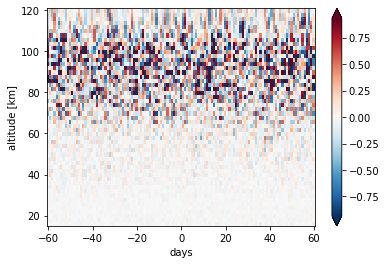

In [129]:
sea_gw_u_cma_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the u-component of gravity waves

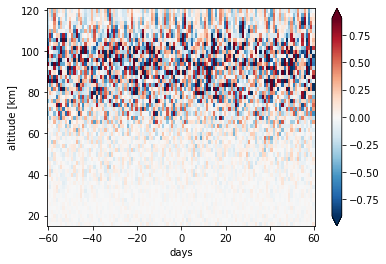

In [130]:
sea_gw_u_cma_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### v-component of gravity waves

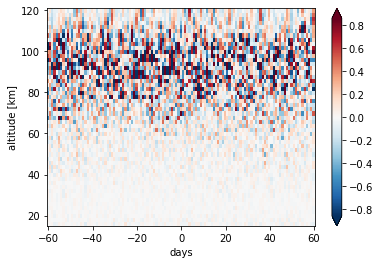

In [131]:
sea_gw_v_cma_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the v-component of gravity waves

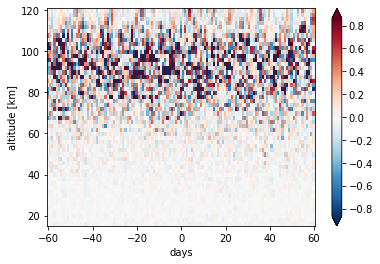

In [132]:
sea_gw_v_cma_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Total kinetic energy of gravity waves

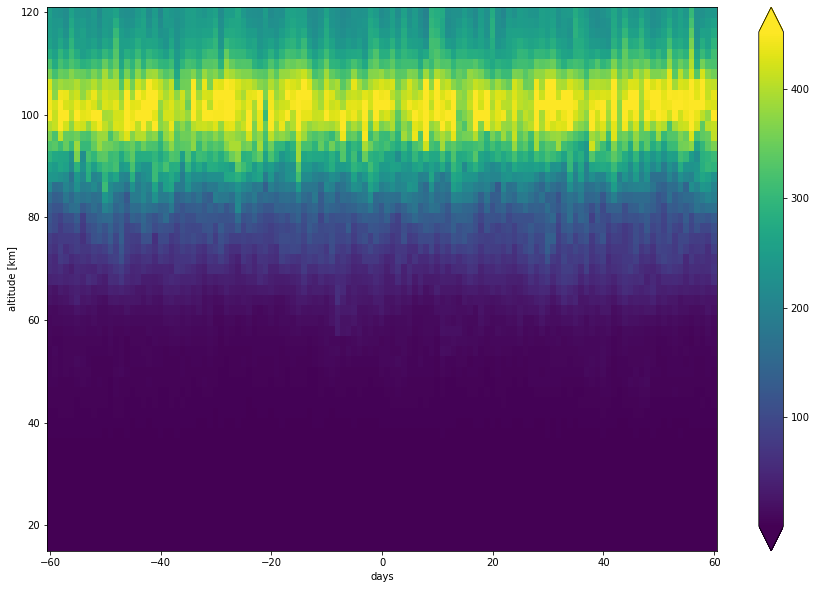

In [133]:
sea_gw_total_energy_cma_gaia.sel(alt=slice(0, 120)).plot(x="days", size=10, robust=True)

##### Anomalies of the total kinetic energy of gravity waves

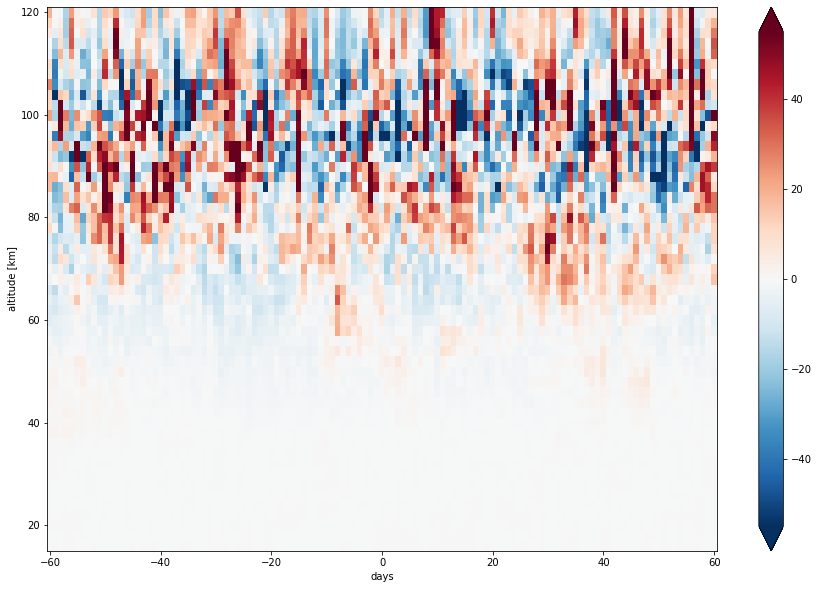

In [134]:
sea_gw_total_energy_cma_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", size=10, robust=True
)

#### Davis (Antarctic)

In [135]:
gw_u_dav_gaia = grav_waves_gaia("u", ds_dav_gaia)
gw_v_dav_gaia = grav_waves_gaia("v", ds_dav_gaia)
gw_total_energy_dav_gaia = kin_energy_grav_waves_gaia(ds_dav_gaia)

sea_gw_u_dav_gaia = sea(60, "Dav", gw_u_dav_gaia)
sea_gw_v_dav_gaia = sea(60, "Dav", gw_v_dav_gaia)
sea_gw_total_energy_dav_gaia = sea(60, "Dav", gw_total_energy_dav_gaia)


gw_total_energy_dav_gaia_anomalie = anomalie("day", gw_total_energy_dav_gaia)
gw_u_dav_gaia_anomalie = anomalie("day", gw_u_dav_gaia)
gw_v_dav_gaia_anomalie = anomalie("day", gw_v_dav_gaia)

sea_gw_total_energy_dav_gaia_anomalie = sea(
    60, "Dav", gw_total_energy_dav_gaia_anomalie
)
sea_gw_u_dav_gaia_anomalie = sea(60, "Dav", gw_u_dav_gaia_anomalie)
sea_gw_v_dav_gaia_anomalie = sea(60, "Dav", gw_v_dav_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]


##### u-component of gravity waves

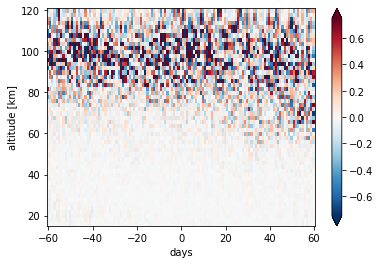

In [136]:
sea_gw_u_dav_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the u-component of gravity waves

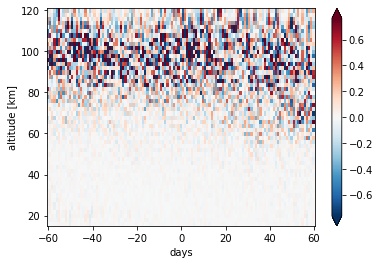

In [137]:
sea_gw_u_dav_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### v-component of gravity waves

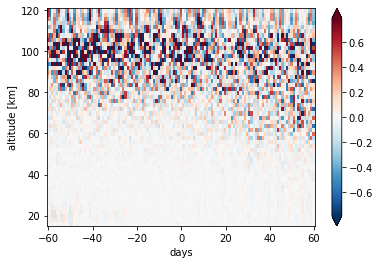

In [138]:
sea_gw_v_dav_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the v-component of gravity waves

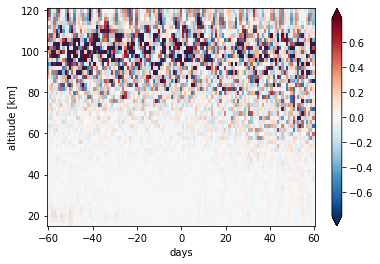

In [139]:
sea_gw_v_dav_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Total kinetic energy of gravity waves

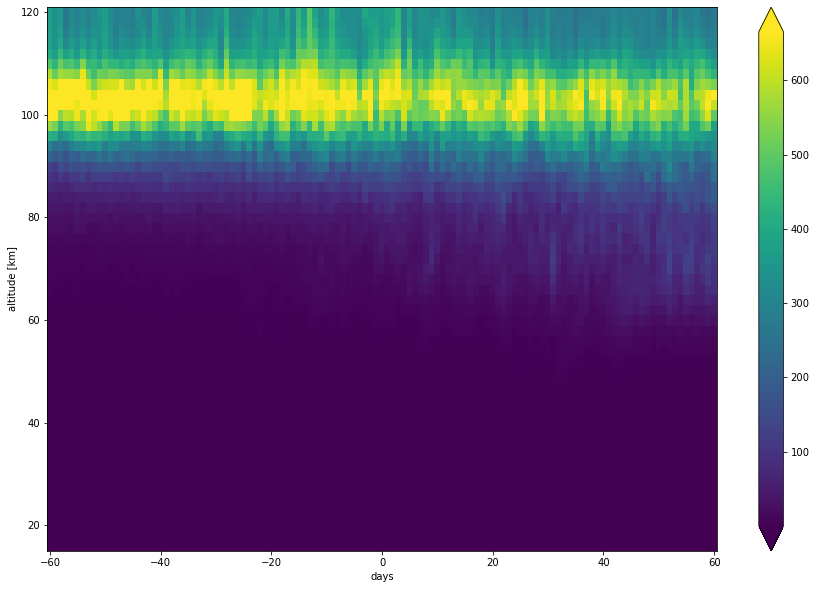

In [140]:
sea_gw_total_energy_dav_gaia.sel(alt=slice(0, 120)).plot(x="days", size=10, robust=True)

##### Anomalies of the total kinetic energy of gravity waves

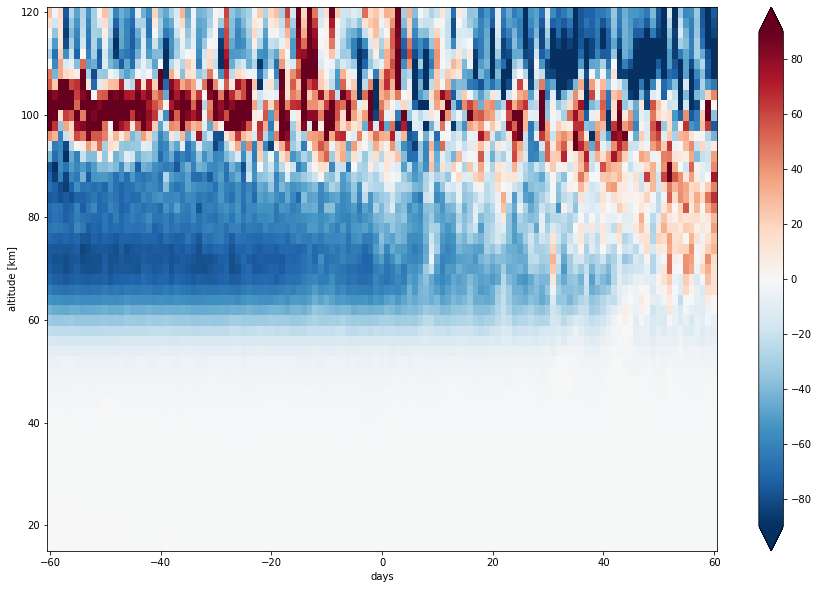

In [141]:
sea_gw_total_energy_dav_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", size=10, robust=True
)

#### Kiruna, Norrbotten (Sweden)

In [142]:
gw_u_kir_gaia = grav_waves_gaia("u", ds_kir_gaia)
gw_v_kir_gaia = grav_waves_gaia("v", ds_kir_gaia)
gw_total_energy_kir_gaia = kin_energy_grav_waves_gaia(ds_kir_gaia)

sea_gw_u_kir_gaia = sea(60, "Kir", gw_u_kir_gaia)
sea_gw_v_kir_gaia = sea(60, "Kir", gw_v_kir_gaia)
sea_gw_total_energy_kir_gaia = sea(60, "Kir", gw_total_energy_kir_gaia)


gw_total_energy_kir_gaia_anomalie = anomalie("day", gw_total_energy_kir_gaia)
gw_u_kir_gaia_anomalie = anomalie("day", gw_u_kir_gaia)
gw_v_kir_gaia_anomalie = anomalie("day", gw_v_kir_gaia)

sea_gw_total_energy_kir_gaia_anomalie = sea(
    60, "Kir", gw_total_energy_kir_gaia_anomalie
)
sea_gw_u_kir_gaia_anomalie = sea(60, "Kir", gw_u_kir_gaia_anomalie)
sea_gw_v_kir_gaia_anomalie = sea(60, "Kir", gw_v_kir_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]


##### u-component of gravity waves

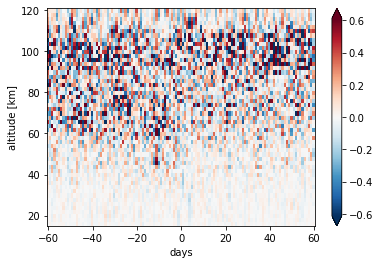

In [143]:
sea_gw_u_kir_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the u-component of gravity waves

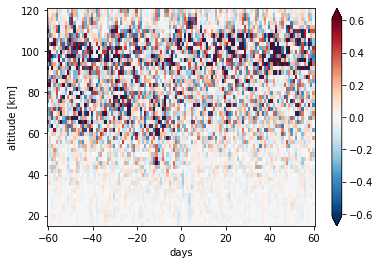

In [144]:
sea_gw_u_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### v-component of gravity waves

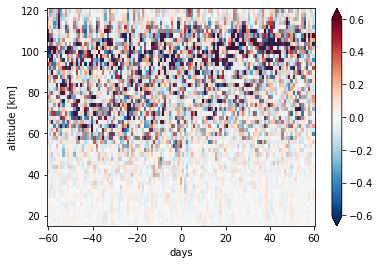

In [145]:
sea_gw_v_kir_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Anomalies of the v-component of gravity waves

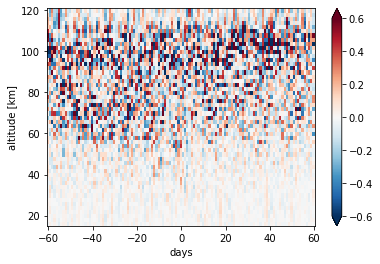

In [146]:
sea_gw_v_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(x="days", robust=True)

##### Total kinetic energy of gravity waves

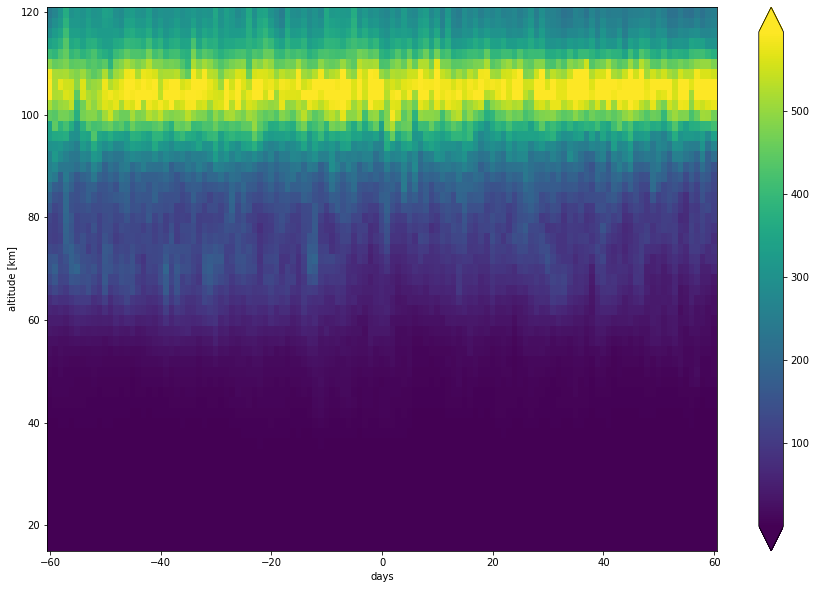

In [147]:
sea_gw_total_energy_kir_gaia.sel(alt=slice(0, 120)).plot(x="days", size=10, robust=True)

##### Anomalies of the total kinetic energy of gravity waves

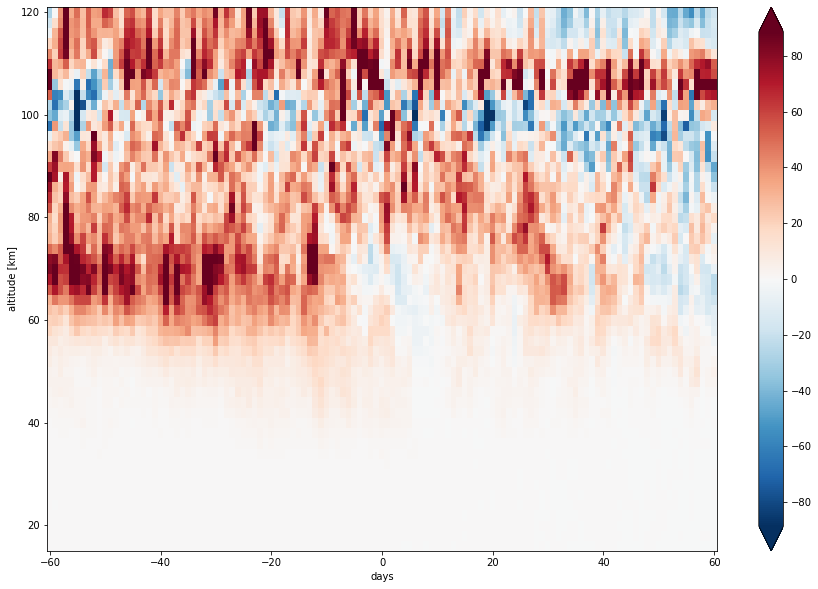

In [148]:
sea_gw_total_energy_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", size=10, robust=True
)

# -------------------------------------------------------------------------------------------------------------

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


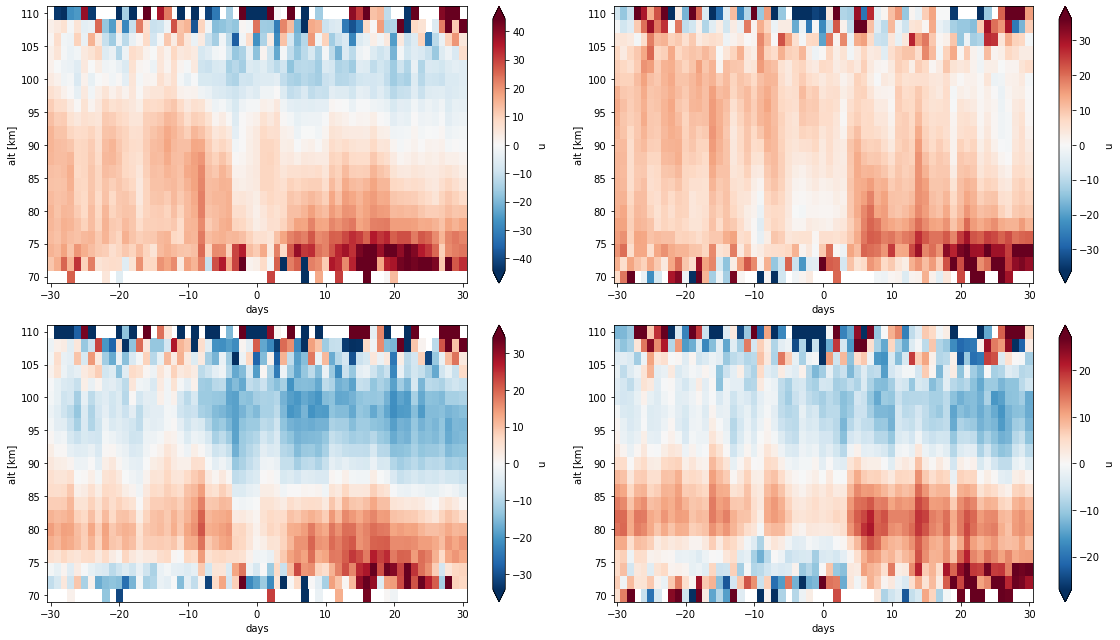

In [149]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_col.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 0])
sea_u_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 0])
sea_u_kir.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 1])
sea_u_kir_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u_clim_anomaly_col_kir_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


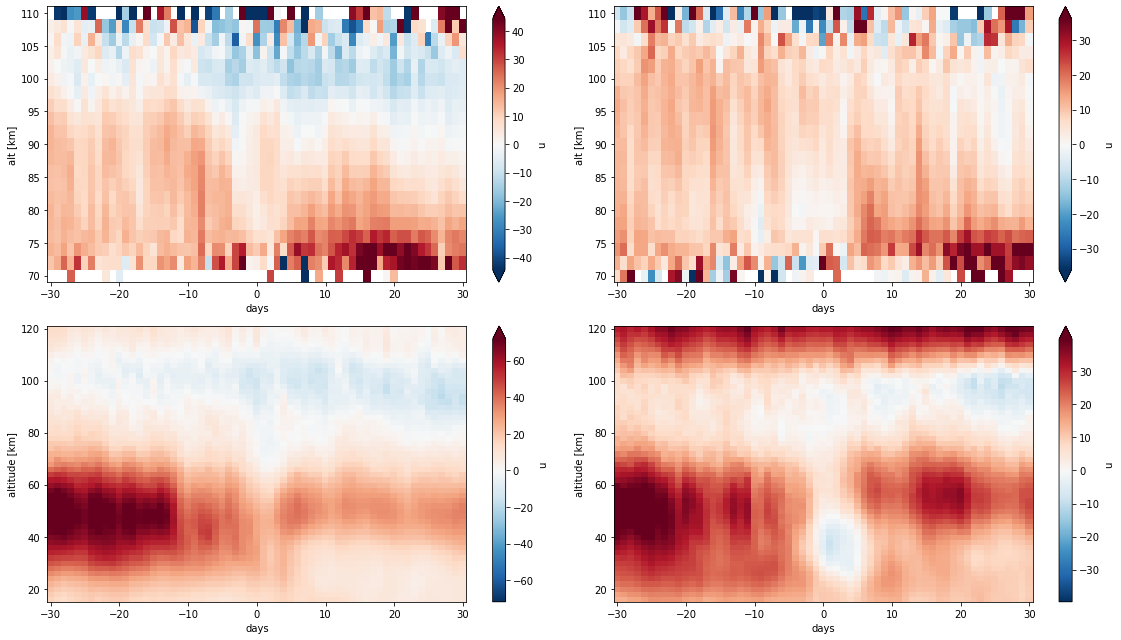

In [150]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_col.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 0])
sea_u_col_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True, ax=axes[1, 0])
sea_u_kir.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 1])
sea_u_kir_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u_clim_gaia_col_kir_panel.png")

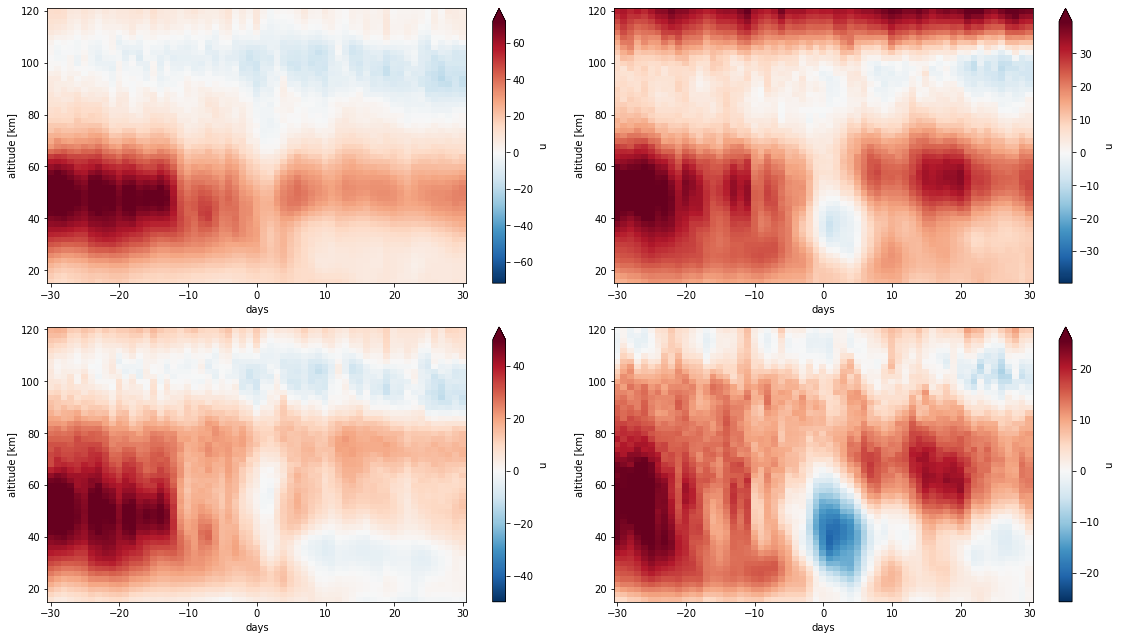

In [151]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_col_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True, ax=axes[0, 0])
sea_u_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, ax=axes[1, 0]
)
sea_u_kir_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True, ax=axes[0, 1])
sea_u_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, ax=axes[1, 1]
)

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u_gaia_col_kir_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


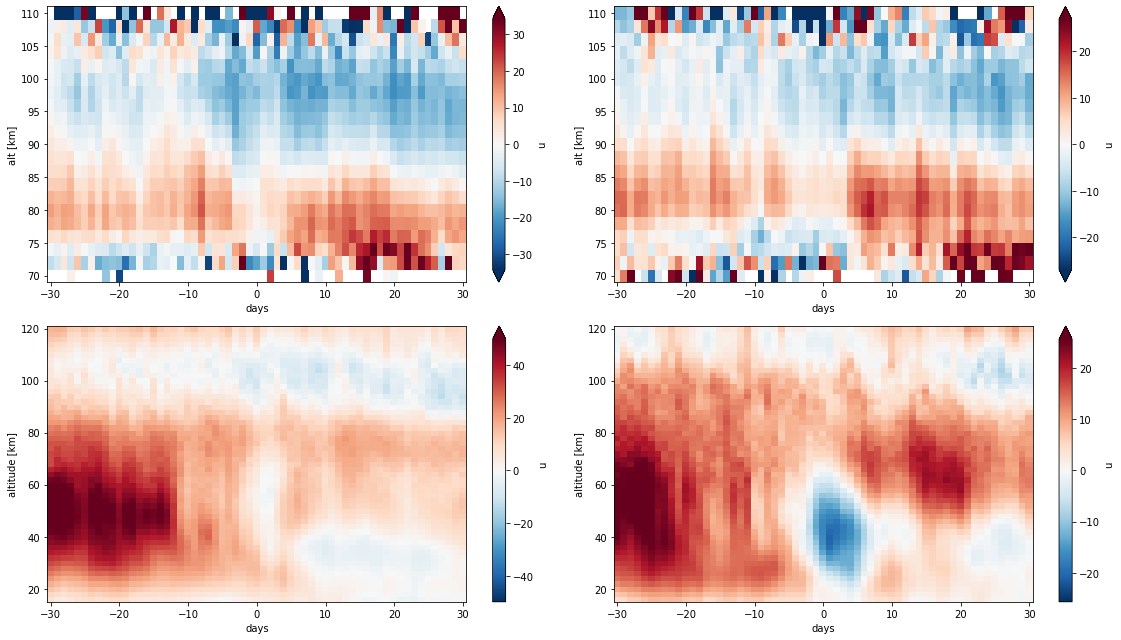

In [152]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 0])
sea_u_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, ax=axes[1, 0]
)
sea_u_kir_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 1])
sea_u_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, ax=axes[1, 1]
)

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u_anomaly_gaia_col_kir_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


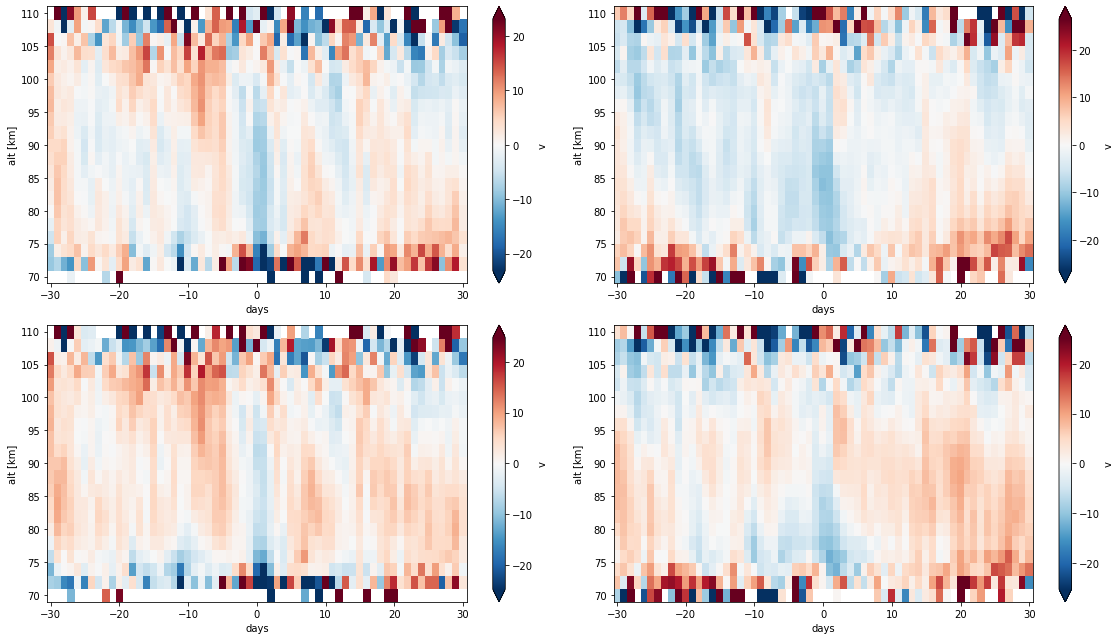

In [153]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_v_col.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 0])
sea_v_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 0])
sea_v_kir.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 1])
sea_v_kir_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/v_clim_anomaly_col_kir_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


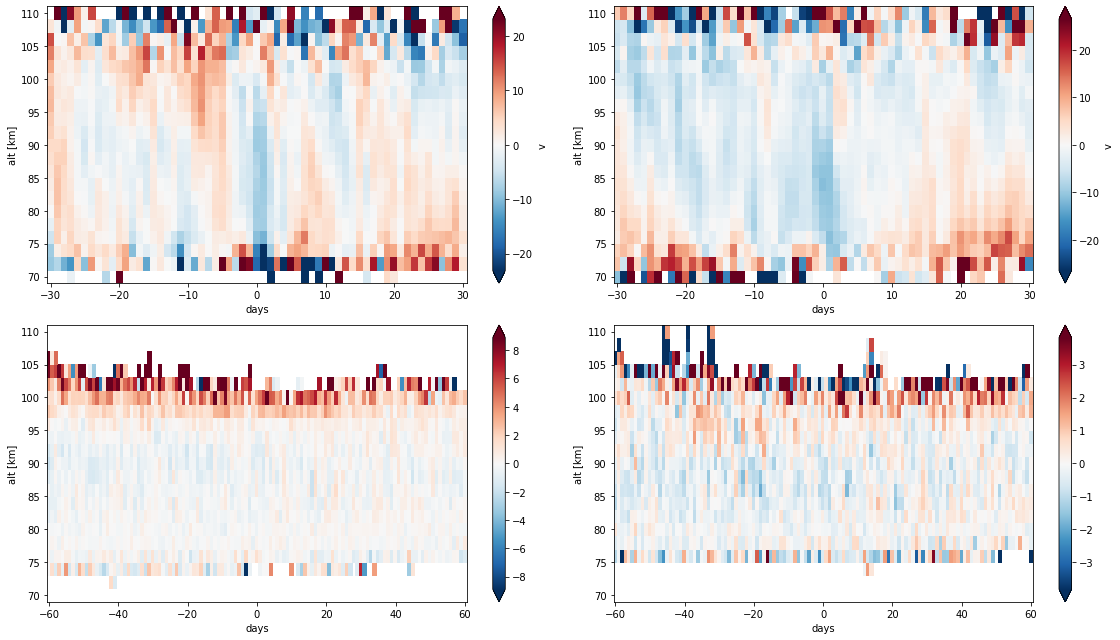

In [154]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_v_col.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 0])
sea_gw_v_col.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 0])
sea_v_kir.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 1])
sea_gw_v_kir.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/v_v-gw_clim_col_kir_panel.png")

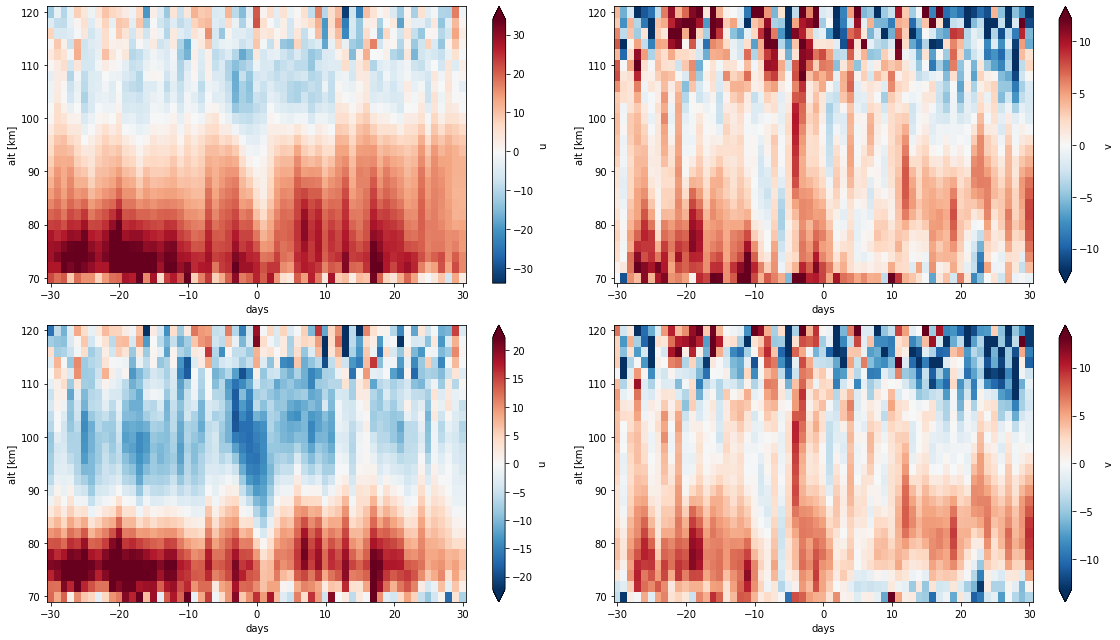

In [155]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_cma.plot(x="days", robust=True, ax=axes[0, 0])
sea_u_cma_anomalie.plot(x="days", robust=True, ax=axes[1, 0])
sea_v_cma.plot(x="days", robust=True, ax=axes[0, 1])
sea_v_cma_anomalie.plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u-v_clim-anomaly_cma_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


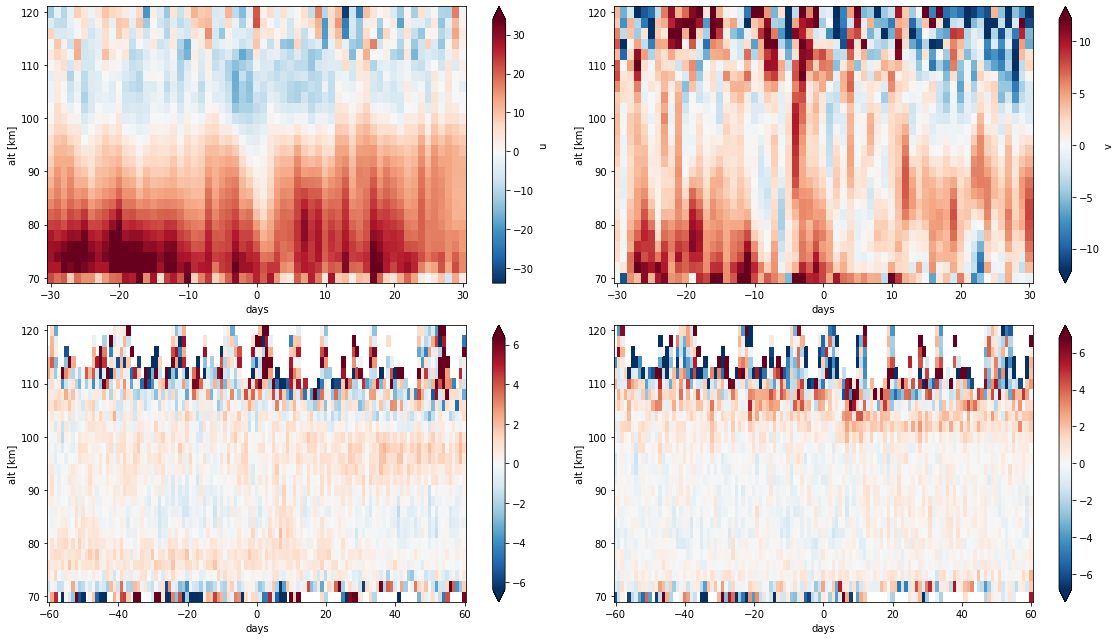

In [156]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_cma.plot(x="days", robust=True, ax=axes[0, 0])
sea_gw_u_cma.plot(x="days", robust=True, ax=axes[1, 0])
sea_v_cma.plot(x="days", robust=True, ax=axes[0, 1])
sea_gw_v_cma.plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u_u-gw_v_v-gw_clim_cma_panel.png")

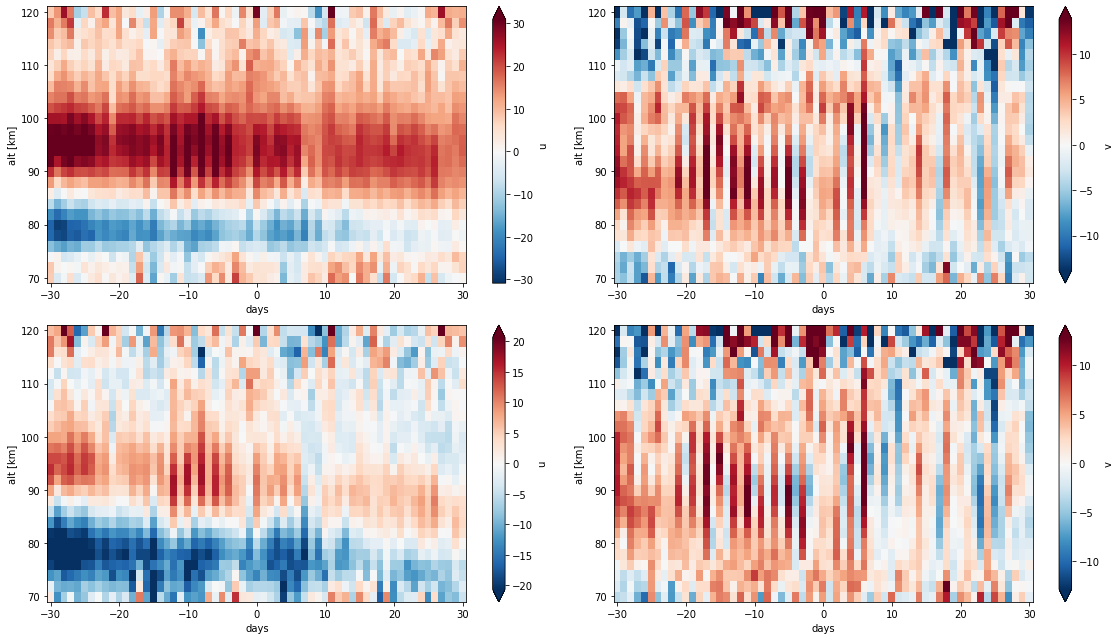

In [157]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_rio.plot(x="days", robust=True, ax=axes[0, 0])
sea_u_rio_anomalie.plot(x="days", robust=True, ax=axes[1, 0])
sea_v_rio.plot(x="days", robust=True, ax=axes[0, 1])
sea_v_rio_anomalie.plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u-v_clim-anomaly_rio_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


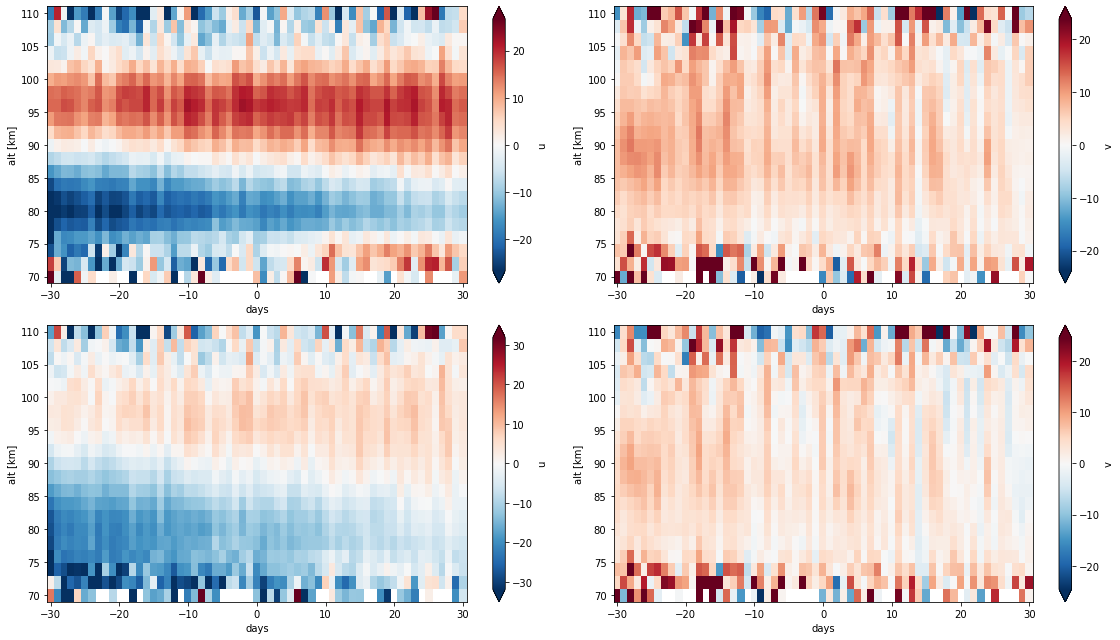

In [158]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_u_dav.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 0])
sea_u_dav_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 0])
sea_v_dav.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 1])
sea_v_dav_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/u-v_clim-anomaly_dav_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


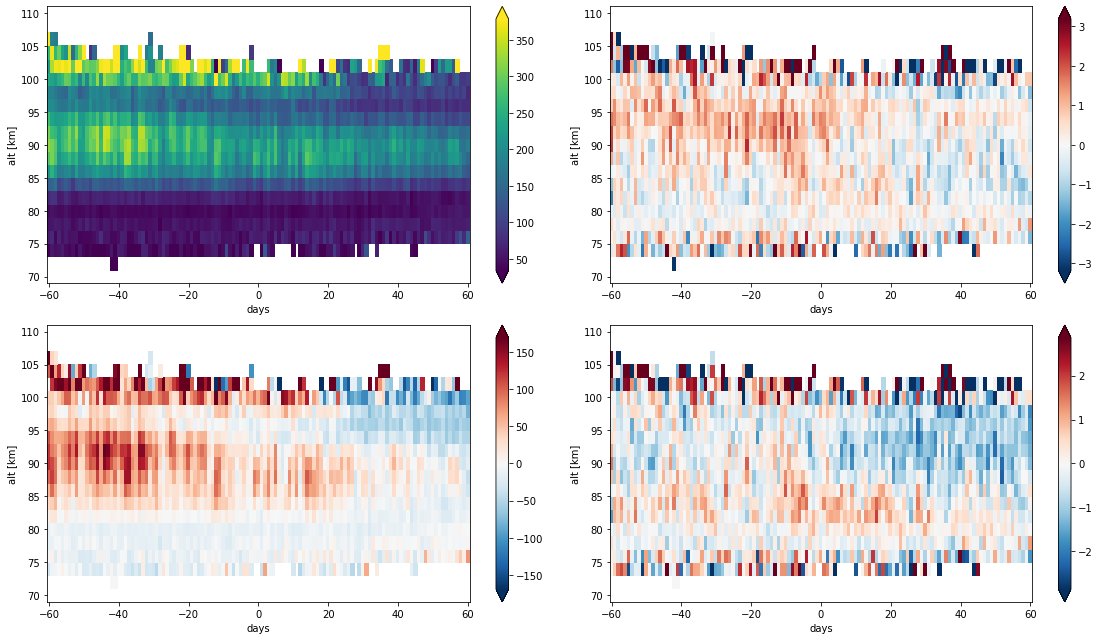

In [159]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_gw_total_energy_col.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[0, 0]
)
sea_gw_total_energy_col_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[1, 0]
)
sea_gw_u_col.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[0, 1])
sea_gw_u_col_anomalie.sel(alt=slice(70, 110)).plot(x="days", robust=True, ax=axes[1, 1])

plt.tight_layout()
plt.draw()
plt.savefig("graphics/gw_tot-u_clim-anomaly_col_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


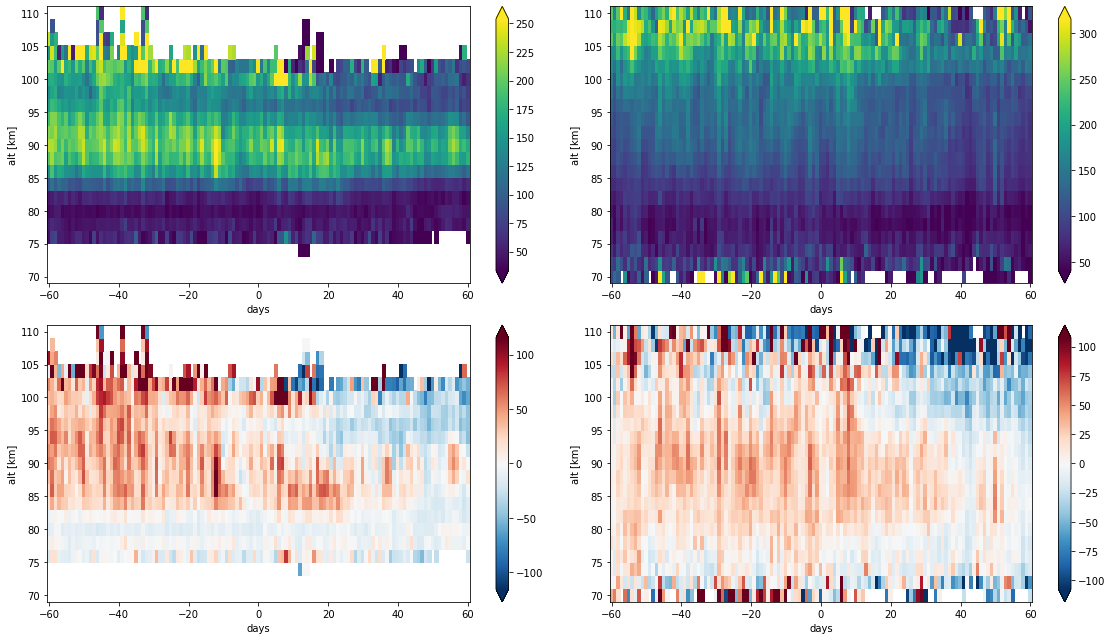

In [160]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_gw_total_energy_kir.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[0, 0]
)
sea_gw_total_energy_kir_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[1, 0]
)
sea_gw_total_energy_cma.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[0, 1]
)
sea_gw_total_energy_cma_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[1, 1]
)

plt.tight_layout()
plt.draw()
plt.savefig("graphics/gw_tot_clim-anomaly_kir-cma_panel.png")

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


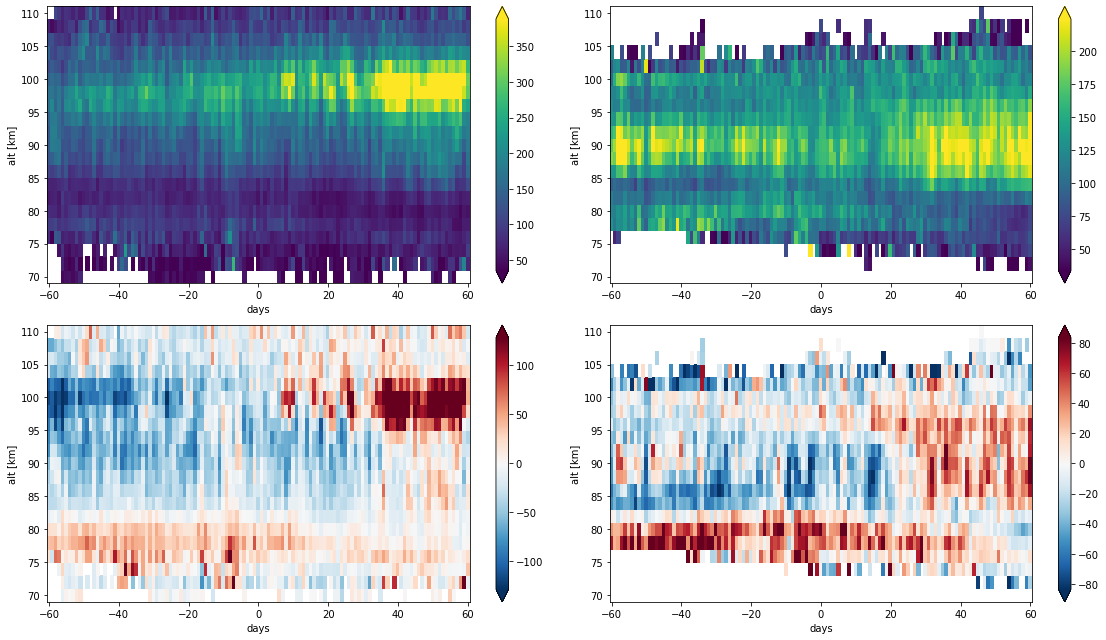

In [161]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_gw_total_energy_rio.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[0, 0]
)
sea_gw_total_energy_rio_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[1, 0]
)
sea_gw_total_energy_dav.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[0, 1]
)
sea_gw_total_energy_dav_anomalie.sel(alt=slice(70, 110)).plot(
    x="days", robust=True, ax=axes[1, 1]
)

plt.tight_layout()
plt.draw()
plt.savefig("graphics/gw_tot_clim-anomaly_rio-dav_panel.png")

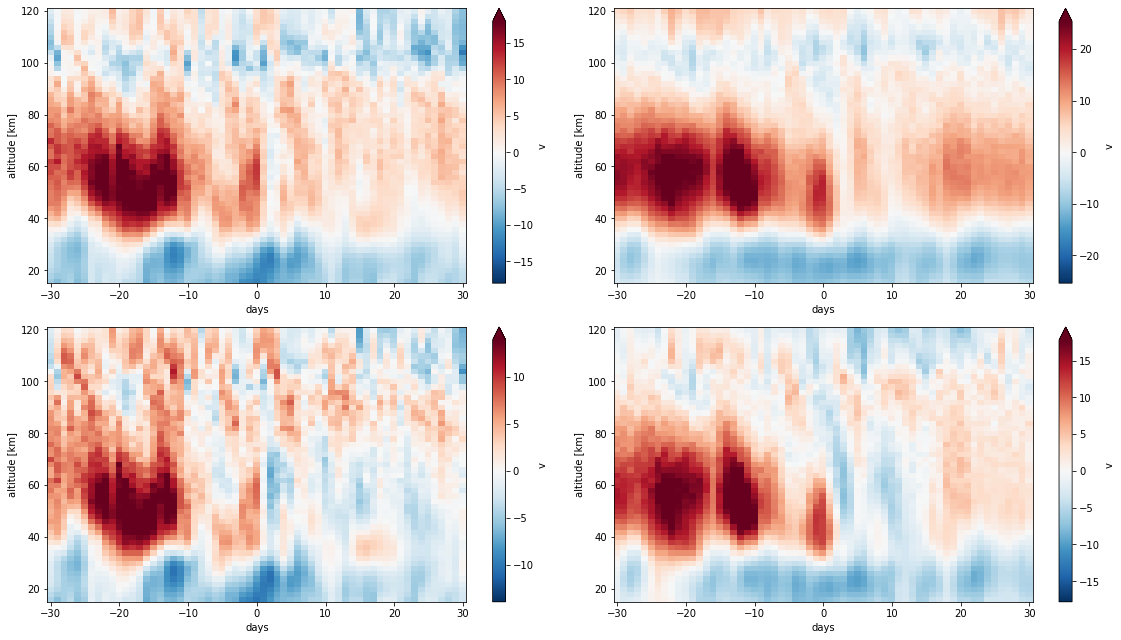

In [162]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16, 9])

sea_v_col_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True, ax=axes[0, 0])
sea_v_col_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, ax=axes[1, 0]
)
sea_v_kir_gaia.sel(alt=slice(0, 120)).plot(x="days", robust=True, ax=axes[0, 1])
sea_v_kir_gaia_anomalie.sel(alt=slice(0, 120)).plot(
    x="days", robust=True, ax=axes[1, 1]
)

plt.tight_layout()
plt.draw()
plt.savefig("graphics/v_gaia_col_kir_panel.png")

# -------------------------------------------------------------------------------------------------------------